In [1]:
import numpy as np
import matplotlib.pyplot as plt
import apogee.select as apsel
import apogee.tools.read as apread
from galpy.util import bovy_coords
from galpy.orbit import Orbit, Orbits
from galpy.potential import MWPotential2014
from galpy.potential import SolidBodyRotationWrapperPotential, DehnenSmoothWrapperPotential, \
   CosmphiDiskPotential, DehnenBarPotential, LogarithmicHaloPotential, SpiralArmsPotential
import mwdust
import gaia_tools
import tqdm
from gaia_tools import xmatch
from astropy.io import fits
import gaia_tools.load as gload
import dill as pickle
import multiprocessing
import os
import emcee
import scipy.optimize as op
from scipy import interpolate
from scipy.stats import gaussian_kde
import utils
import sys
from isodist import FEH2Z, Z2FEH
import corner
params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 14, 'font.family': 'serif'}
plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload

# Weighing _Gaia_-Enceladus through the density modelling of APOGEE data

We are going to use forward modelling of APOGEE star counts to fit density models to stars with $\mathrm{[Fe/H]}$ and $\mathrm{[Mg/Fe]}$ abundances in the region which was found to be dominated by stars in _Gaia_-Enceladus in Mackereth et al. (2019a). By correcting for the selection effects of the APOGEE observations, we can derive a precise constraint on the mass of the remnant.

First lets load in all the data we need. We are going to use the distance estimates from Leung & Bovy (2019b), as provided through the `apogee` python package. We also need to evaluate the selection function for DR14, and convert that to the 'effective' selection function (these steps can take some time and computational power!):

In [2]:
#load allStar (main sample w/ Leung & Bovy distances, removing duplicates)
allstar = apread.allStar(main=True, rmdups=True,use_astroNN_distances=True)
print(str(len(allstar))+' stars in total sample.')

/anaconda3/lib/python3.7/site-packages/apogee-1.-py3.7.egg/apogee/tools/read.py:1220: UserWarning: Adding distances from Leung & Bovy (2019b)
  warnings.warn("Adding distances from Leung & Bovy (2019b)")



100%|██████████| 43720/43720 [00:04<00:00, 10600.23it/s]


137748 stars in total sample.                                                   


In [3]:
#load selection function/statIndx/effsel if they exist, if not, evaluate and pickle (set force to True for brute force re-evaluation)
force = False
if os.path.exists('../sav/apogeeCombinedSF.dat') and not force:
    with open('../sav/apogeeCombinedSF.dat', 'rb') as f:
        apo = pickle.load(f)
else:
    apo = apsel.apogeeCombinedSelect()
    del apo._specdata, apo._photdata
    with open('../sav/apogeeCombinedSF.dat', 'wb') as f:
        pickle.dump(apo, f)
        
#determine statistical sample and pickle file
if os.path.exists('../sav/statIndx.dat') and not force:
    with open('../sav/statIndx.dat', 'rb') as f:
        statIndx = pickle.load(f)
else:
    statIndx = apo.determine_statistical(allstar)
    with open('../sav/statIndx.dat', 'wb') as f:
        pickle.dump(statIndx, f)

In [4]:
def _calc_effsel_onelocation(i): 
    loc = apo._locations[i]
    if np.sum([np.nansum(apo._nspec_short[i]),np.nansum(apo._nspec_medium[i]),np.nansum(apo._nspec_long[i])]) < 1.:
        effsel = np.zeros(len(ds))
    elif apo.JKmin(loc) >= 0.5:
        effsel = apof(loc, ds, MH=H, JK0=(J-K))*apo.area(loc)
    elif apo.JKmin(loc) < 0.5:
        effsel = apof(loc, ds, MH=p3H, JK0=(p3J-p3K))*apo.area(loc)
    return effsel
force = False
nsamples=2000
ndistmods=301
minmax_distmods=[7.,19.]
nthreads = int(multiprocessing.cpu_count()//8)
sys.stdout.write('\r'+"Compiling isochrone grid and sampling for H and J-K distribution of underlying sample\r")
sys.stdout.flush()
dmap = mwdust.Combined15()
apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap)
niso, p3niso = utils.APOGEE_iso_samples(nsamples)
H, J, K = niso['H'], niso['J'], niso['K']
p3H, p3J, p3K = p3niso['H'], p3niso['J'], p3niso['K']
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)
if os.path.exists('../essf/effsel_grid_inclArea.dat') and not force:
    sys.stdout.write('\r'+"loading saved effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with open('../essf/effsel_grid_inclArea.dat', 'rb') as f:
        outarea = pickle.load(f)
else:
    sys.stdout.write('\r'+"calculating effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with multiprocessing.Pool(nthreads) as p:
        outarea = list(tqdm.tqdm(p.imap(_calc_effsel_onelocation, range(0,len(apo._locations))), total=len(apo._locations)))
    outarea = np.array(outarea)
    with open('../essf/effsel_grid_inclArea.dat', 'wb') as f:
        pickle.dump(outarea, f)

100%|██████████| 71/71 [00:02<00:00, 31.62it/s]


## Selecting probable _Gaia_-Enceladus stars

We make simple cuts in abundance space to get stars which are likely members of _Gaia_-Enceladus. This keeps things simple later when reconstructing the selection function. We also select a _control_ sample of stars with higher $\mathrm{[Mg/Fe]}$ at the same $\mathrm{[Fe/H]}$, to ensure that the _Gaia_-Enceladus population we find is indeed different in nature to the Milky Way halo stars at that metallicity.

First, lets plot the samples in $\mathrm{[Mg/Fe]}-\mathrm{[Fe/H]}$ space:

150 stars in the Gaia-Enceladus sample
245 stars in the control sample


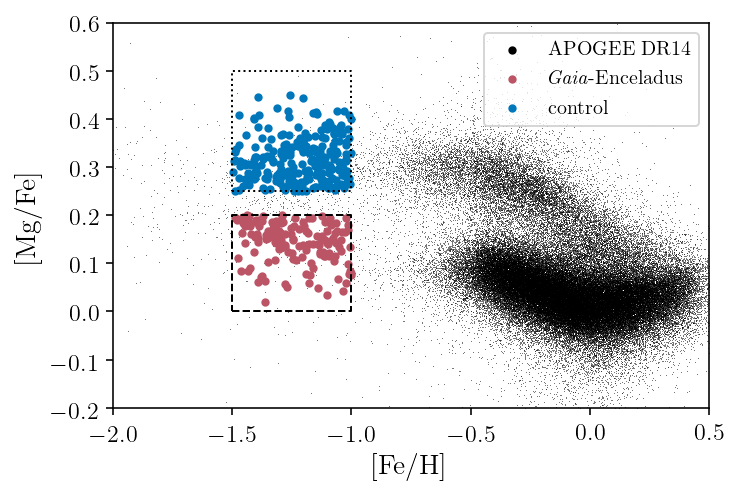

In [5]:
# find stars with Gaia-Enceladus-like abundances, and select control sample. Cut to 1. < Log(g) < 3. (giants?).
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, columnwidth)
accreted = (allstar[statIndx]['FE_H'] > -1.5) & (allstar[statIndx]['FE_H'] < -1.) & (allstar[statIndx]['MG_FE'] < 0.2) & (allstar[statIndx]['MG_FE'] > 0.) & (allstar[statIndx]['LOGG'] > 1.) & (allstar[statIndx]['LOGG'] < 3.)
control = (allstar[statIndx]['FE_H'] > -1.5) & (allstar[statIndx]['FE_H'] < -1.) & (allstar[statIndx]['MG_FE'] > 0.25) & (allstar[statIndx]['MG_FE'] < 0.5) & (allstar[statIndx]['LOGG'] > 1.) & (allstar[statIndx]['LOGG'] < 3.)
plt.scatter(allstar[statIndx]['FE_H'], allstar[statIndx]['MG_FE'], s=0.1, color='Black', lw=0., rasterized=True)
plt.scatter(-9999,-9999,s=10,color='Black', label=r'APOGEE DR14')
plt.scatter(allstar[statIndx][accreted]['FE_H'], allstar[statIndx][accreted]['MG_FE'], s=10, color='#BB5566', label=r'$\emph{Gaia}$-Enceladus')
plt.scatter(allstar[statIndx][control]['FE_H'], allstar[statIndx][control]['MG_FE'], s=10, color='#0077BB', label=r'control')
plt.plot([-1.5,-1.,-1,-1.5,-1.5], [0.,0.,0.2,0.2,0.], linestyle='dashed', c='Black')
plt.plot([-1.5,-1.,-1,-1.5,-1.5], [0.25,0.25,0.5,0.5,0.25], linestyle='dotted', c='Black')
plt.legend(loc=1)
print(str(sum(accreted))+' stars in the Gaia-Enceladus sample')
print(str(sum(control))+' stars in the control sample')
plt.xlim(-2.,0.5)
plt.ylim(-0.2,0.6)
fig.tight_layout()
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathrm{[Mg/Fe]}$')

plt.savefig('../plots/afe_feh_sample.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.savefig('../plots/afe_feh_sample.png', format='png', bbox_inches='tight', dpi=400)

And a plot showing the spatial distribution of the stars:

In [6]:
#Calculate the XYZ and Rphiz coordinates of the two samples and the rest of APOGEE DR14.
def allstar_to_coords(dat):
    l, b, d = dat['GLON'], dat['GLAT'], dat['weighted_dist']/1e3
    XYZ = bovy_coords.lbd_to_XYZ(l,b,d, degree=True)
    Rphiz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8., Zsun=0.02)
    return XYZ, Rphiz
    
matched = allstar[statIndx][accreted]
cmatched = allstar[statIndx][control]
XYZ, Rphiz = allstar_to_coords(matched)
cXYZ, cRphiz = allstar_to_coords(cmatched)
allXYZ, allRphiz = allstar_to_coords(allstar[statIndx])

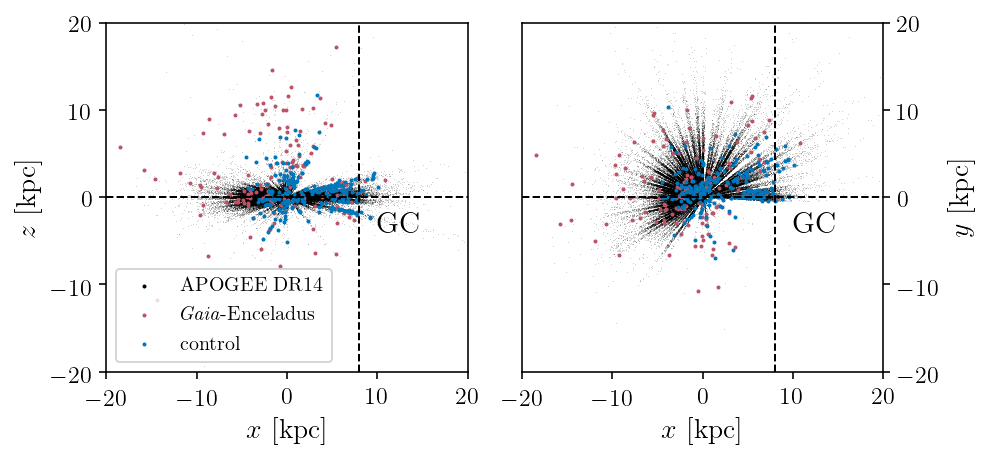

In [7]:
#Plot the spatial distribution of the stars in x-y and x-z
fig, ax = plt.subplots(1,2)
fig.set_size_inches(textwidth,columnwidth)
ax[0].scatter(allXYZ[:,0], allXYZ[:,2], c='Black', s=0.1, lw=0., alpha=0.3, rasterized=True)
ax[0].scatter(-9999,-9999,s=1.,color='Black', label=r'APOGEE DR14')
ax[0].scatter(XYZ[:,0], XYZ[:,2], c='#BB5566', s=1., label=r'$\emph{Gaia}$-Enceladus')
ax[0].scatter(cXYZ[:,0], cXYZ[:,2], c='#0077BB', s=1., label=r'control')
ax[0].axvline(8., c='Black', linestyle='dashed')
ax[0].axhline(0., c='Black', linestyle='dashed')
ax[0].set_ylim(-20,20)
ax[0].set_xlim(-20,20)

ax[1].scatter(allXYZ[:,0], allXYZ[:,1], c='Black', s=0.1, lw=0., alpha=0.3, rasterized=True)
ax[1].scatter(XYZ[:,0], XYZ[:,1], c='#BB5566', s=1.)
ax[1].scatter(cXYZ[:,0], cXYZ[:,1], c='#0077BB', s=1.)
ax[1].axvline(8., c='Black', linestyle='dashed')
ax[1].axhline(0., c='Black', linestyle='dashed')
ax[1].set_ylim(-20,20)
ax[1].set_xlim(-20,20)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[0].set_xlabel(r'$x\ \mathrm{[kpc]}$')
ax[1].set_xlabel(r'$x\ \mathrm{[kpc]}$')
ax[0].set_ylabel(r'$z\ \mathrm{[kpc]}$')
ax[1].set_ylabel(r'$y\ \mathrm{[kpc]}$')
ax[0].text(10,-4,r'GC', fontsize=15)
ax[1].text(10,-4,r'GC', fontsize=15)
fig.tight_layout()
ax[0].legend(loc=3)
plt.savefig('../plots/XYZ_sample.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.savefig('../plots/ZYZ_sample.png', format='png', bbox_inches='tight', dpi=400)

and then we can cross-match with Gaia DR2, and estimate orbital parameters for these stars, hoping that the Enceladus sample shows the strong characteristic peak of strongly radial orbits:

In [21]:
gaiaxmatch = fits.open('../sav/allStar_l31c2_GaiaDR2_crossmatch_withpms.fits')[1].data

orbits = utils.join_on_id(allstar,gaiaxmatch)

In [22]:
orbits = orbits[orbits['ra_dec_corr'] != -9999.]

In [23]:
ra, dec, parallax, pmra, pmdec, RV = orbits['ra'], orbits['dec'], orbits['weighted_dist']/1e3, orbits['pmra'], orbits['pmdec'], orbits['VHELIO_AVG']
radec, raparallax, rapmra, rapmdec = orbits['ra_dec_corr'], 0., orbits['ra_pmra_corr'], orbits['ra_pmdec_corr']
decparallax, decpmra, decpmdec = 0., orbits['dec_pmra_corr'], orbits['dec_pmdec_corr']
parallaxpmra, parallaxpmdec = 0., 0.
pmrapmdec = orbits['pmra_pmdec_corr']
ra_e, dec_e, parallax_e, pmra_e, pmdec_e, RV_e = orbits['ra_error'], orbits['dec_error'], orbits['weighted_dist_error']/1e3, orbits['pmra_error'], orbits['pmdec_error'], orbits['VERR']

cov = np.zeros([len(orbits),6,6])
cov[:,0] = np.dstack([ra_e**2, ra_e*dec_e*radec, ra_e*parallax_e*raparallax, ra_e*pmra_e*rapmra, ra_e*dec_e*rapmdec, np.zeros(len(orbits))])[0]
cov[:,1,1:] = np.dstack([dec_e**2, dec_e*parallax_e*decparallax, dec_e*pmra_e*decpmra, dec_e*pmdec_e*decpmdec, np.zeros(len(orbits))])[0]
cov[:,2,2:] = np.dstack([parallax_e**2, parallax_e*pmra_e*parallaxpmra, parallax_e*pmdec_e*parallaxpmdec, np.zeros(len(orbits))])[0]
cov[:,3,3:] = np.dstack([pmra_e**2, pmra_e*pmdec_e*pmrapmdec, np.zeros(len(orbits))])[0]
cov[:,4,4:] = np.dstack([pmdec_e**2, np.zeros(len(orbits))])[0]
cov[:,5,5] = RV_e**2
cov[:,:,0] = cov[:,0]
cov[:,1:,1] = cov[:,1,1:]
cov[:,2:,2] = cov[:,2,2:]
cov[:,3:,3] = cov[:,3,3:]
cov[:,4:,4] = cov[:,4,4:]

mean = np.dstack([ra,dec,parallax,pmra,pmdec,RV])[0]

omask = np.all(np.isfinite(mean), axis=1) & (np.all(np.isfinite(mean), axis=1))


In [24]:
o_accreted = (orbits['FE_H'] > -1.5) & (orbits['FE_H'] < -1.) & (orbits['MG_FE'] < 0.2) & (orbits['MG_FE'] > 0.) & (orbits['LOGG'] > 1.) & (orbits['LOGG'] < 3.)
o_control = (orbits['FE_H'] > -1.5) & (orbits['FE_H'] < -1.) & (orbits['MG_FE'] > 0.25) & (orbits['MG_FE'] < 0.5) & (orbits['LOGG'] > 1.) & (orbits['LOGG'] < 3.)

In [25]:
o_mask = o_accreted & omask
sampled_vxvv_accreted = np.empty((len(orbits[o_mask]),100,6))
for i in tqdm.tqdm_notebook(range(len(orbits[o_mask]))):
    try:
        sampled_vxvv_accreted[i] = np.random.multivariate_normal(mean[o_mask][i], cov[o_mask][i], 100)
    except ValueError:
        print(mean[o_mask][i])
        print(cov[o_mask][i])
        
o_mask = o_control & omask
sampled_vxvv_control = np.empty((len(orbits[o_mask]),100,6))
for i in tqdm.tqdm_notebook(range(len(orbits[o_mask]))):
    try:
        sampled_vxvv_control[i] = np.random.multivariate_normal(mean[o_mask][i], cov[o_mask][i], 100)
    except ValueError:
        print(mean[o_mask][i])
        print(cov[o_mask][i])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """




/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  




In [26]:
sampled_vxvv_accreted = sampled_vxvv_accreted.reshape(len(orbits[o_accreted&omask])*100,6)

zo = 0.02
ro = 8.
vo=220.
vxvv = np.copy(sampled_vxvv_accreted)
ra, dec= vxvv[:,0], vxvv[:,1]
lb= bovy_coords.radec_to_lb(ra,dec,degree=True)
pmra, pmdec= vxvv[:,3], vxvv[:,4]
pmllpmbb= bovy_coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
d, vlos= vxvv[:,2], vxvv[:,5]

rectgal= bovy_coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
vsolar= np.array([-11.1,245.6,7.25]) #use SBD10 vR and vZ and SGR proper motion vT
vsun= np.array([0.,0.,0.,])+vsolar/vo
X = rectgal[:,0]/ro
Y = rectgal[:,1]/ro
Z = rectgal[:,2]/ro
vx = rectgal[:,3]/vo
vy = rectgal[:,4]/vo
vz = rectgal[:,5]/vo
XYZ = np.dstack([X, Y, Z])[0]
vxyz = np.dstack([vx,vy,vz])[0]

Rpz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
vRvTvz = bovy_coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                            vsun=vsun,
                                                            Xsun=1.,
                                                            Zsun=zo/ro,
                                                            galcen=True)


vxvv_acc = np.dstack([Rpz[:,0], vRvTvz[:,0], vRvTvz[:,1], Rpz[:,2], vRvTvz[:,2], Rpz[:,1]])[0]

sampled_vxvv_control = sampled_vxvv_control.reshape(len(orbits[o_control&omask])*100,6)

vxvv = np.copy(sampled_vxvv_control)
ra, dec= vxvv[:,0], vxvv[:,1]
lb= bovy_coords.radec_to_lb(ra,dec,degree=True)
pmra, pmdec= vxvv[:,3], vxvv[:,4]
pmllpmbb= bovy_coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
d, vlos= vxvv[:,2], vxvv[:,5]
rectgal= bovy_coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
vsolar= np.array([-11.1,245.6,7.25]) #use SBD10 vR and vZ and SGR proper motion vT
vsun= np.array([0.,0.,0.,])+vsolar/vo
X = rectgal[:,0]/ro
Y = rectgal[:,1]/ro
Z = rectgal[:,2]/ro
vx = rectgal[:,3]/vo
vy = rectgal[:,4]/vo
vz = rectgal[:,5]/vo
XYZ = np.dstack([X, Y, Z])[0]
vxyz = np.dstack([vx,vy,vz])[0]
Rpz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
vRvTvz = bovy_coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                            vsun=vsun,
                                                            Xsun=1.,
                                                            Zsun=zo/ro,
                                                            galcen=True)


vxvv_con = np.dstack([Rpz[:,0], vRvTvz[:,0], vRvTvz[:,1], Rpz[:,2], vRvTvz[:,2], Rpz[:,1]])[0]





In [27]:
os = Orbits(vxvv_acc)

es = os.e(analytic=True, pot=MWPotential2014)
rperi = os.rperi(analytic=True, pot=MWPotential2014)
rap = os.rap(analytic=True, pot=MWPotential2014)
zmax = os.zmax(analytic=True, pot=MWPotential2014)

os = Orbits(vxvv_con)

ces = os.e(analytic=True, pot=MWPotential2014)
crperi = os.rperi(analytic=True, pot=MWPotential2014)
crap = os.rap(analytic=True, pot=MWPotential2014)
czmax = os.zmax(analytic=True, pot=MWPotential2014)

/anaconda3/lib/python3.7/site-packages/galpy-1.5.dev0-py3.7-macosx-10.7-x86_64.egg/galpy/util/bovy_coords.py:2037: RuntimeWarning: overflow encountered in sinh
  R= delta*sc.sinh(u)*sc.sin(v)

/anaconda3/lib/python3.7/site-packages/galpy-1.5.dev0-py3.7-macosx-10.7-x86_64.egg/galpy/util/bovy_coords.py:2038: RuntimeWarning: overflow encountered in cosh
  z= delta*sc.cosh(u)*sc.cos(v)



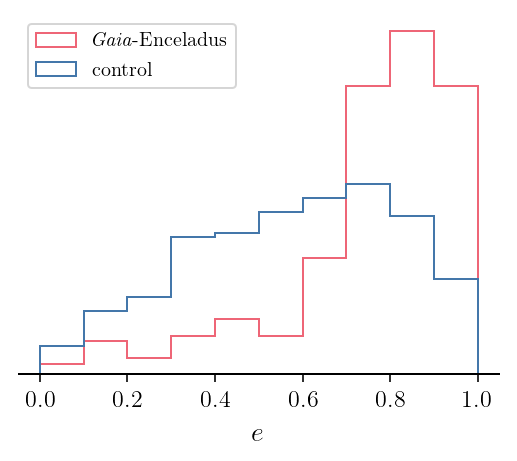

In [29]:
fig = plt.figure()
fig.set_size_inches(1.3*columnwidth,columnwidth)
plt.hist(np.median(np.array(es).reshape(len(orbits[o_accreted&omask]),100), axis=1), range=[0.,1.], density=True, color='#EE6677', histtype='step', label=r'$\emph{Gaia}$-Enceladus')
plt.hist(np.median(np.array(ces).reshape(len(orbits[o_control&o_mask]),100), axis=1), range=[0.,1.], density=True,color='#4477AA', histtype='step', label=r'control')

plt.xlabel(r'$e$')

ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
plt.legend(loc=2)

plt.savefig('../plots/eccentricity-dist.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/eccentricity-dist.png', format='png', dpi=400, bbox_inches='tight')

## Fitting density models

We are going to fit 5 types of general power-law density models to the data, first fixing the model to be spherically symmetric, then with some flattening (axisymmetric), triaxial (with fixed axis rotations), and a model where the triaxial ellipsoid can have some transformation, rotating about the galactic center. Finally, we fit a model which has a triaxial component, and an outlier density model which is spherical, to check if non-enceladus stars get picked up.

In [8]:
#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(outarea < 1e-9, axis=1)
# setup the grid in Rphiz where the effective selection function is evaluated
Rgrid, phigrid, zgrid = utils.Rphizgrid(apo, distmods)
# setup a list of models to fit and their initial parameter guesses.
models = [utils.spherical, utils.axisymmetric, utils.triaxial_norot, utils.triaxial, utils.triaxial_with_spherical_outlier, utils.triaxial_with_fixed_spherical_outlier, utils.triaxial_with_expdisk_outlier, utils.triaxialSP_iorio_qvar]
model_names = ['spherical', 'axisymettric', 'triaxial', 'triaxial w/ transformation', 'triaxial w/ outlier', 'triaxial w/ fixed outlier', 'triaxial w/ exp. outlier', 'triaxial (Iorio et al. 2018)']
inits = [[-2.,], [-2.,0.99], [-2.,0.99,0.99], [-2.,0.99,0.99,0.,0.], [-2.,0.99,0.99,-3.,0.05], [-2.,0.99,0.99,0.05], [-2.,0.99,0.99,0.05], [2.,0.5,0.5,0.8,1/10.,0.5,0.5,0.5]] 
copts, cfopts = [], []
opts, fopts = [], []
# do the MLE fits
for i,model in enumerate(models):
    print('Fitting '+model_names[i]+' model...')
    print('enceladus sample:')
    opt = op.fmin(lambda x: utils.mloglike(x,model, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), inits[i], full_output=True)
    opts.append(opt[0])
    fopts.append(opt[1])
    print(opt[0])
    print('control sample:')
    copt = op.fmin(lambda x: utils.mloglike(x,model, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], cRphiz[:,0], cRphiz[:,1], cRphiz[:,2]), inits[i], full_output=True)
    copts.append(copt[0])
    cfopts.append(copt[1])
    print(copt[0])
    


Fitting spherical model...
enceladus sample:
Optimization terminated successfully.
         Current function value: 1552.827474
         Iterations: 16
         Function evaluations: 32
[-1.10830078]
control sample:
Optimization terminated successfully.
         Current function value: 2149.641817
         Iterations: 14
         Function evaluations: 28
[-1.54707031]
Fitting axisymettric model...
enceladus sample:
Optimization terminated successfully.
         Current function value: 1550.663143
         Iterations: 39
         Function evaluations: 72
[-1.12065731  0.72207116]
control sample:
Optimization terminated successfully.
         Current function value: 2093.229471
         Iterations: 38
         Function evaluations: 73
[-1.69487893  0.43286622]
Fitting triaxial model...
enceladus sample:
Optimization terminated successfully.
         Current function value: 1550.681525
         Iterations: 109
         Function evaluations: 201
[-1.11879915  0.99999997  0.7428162 ]
contro

By looking just at the minimum negative log-likelihood found in each model, we can see that affording the model extra freedom only results in marginally better fits to the data, the inclusion of flattening provides the largest jump in goodness-of-fit.

In [11]:
trec = utils.generate_isogrid()

100%|██████████| 71/71 [00:02<00:00, 30.58it/s]


In [10]:
def implied_mass(densfunc,params):
    isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3) & (trec['logg'] < 3) & (trec['logg'] > 1)
    avmass = utils.average_mass(trec[isomask])
    isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) #& (trec['J']-trec['K'] > 0.3) & (trec['logg'] < 3) & (trec['logg'] > 1)
    massratio = utils.mass_ratio(trec[isomask])
    xyzgrid = np.mgrid[-100.:100.:150j,-100.:100.:150j,-100.:100.:150j]
    delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
    shape = np.shape(xyzgrid.T)
    xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
    rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
    rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    rphizgrid = rphizgrid.reshape(150,150,150,3).T
    rate = densfunc(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=params)/densfunc(8.,0.,0.02, params=params)*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
    sumrate = np.sum(rate)
    norm = len(Rphiz)/sumrate
    fac = norm*(180/np.pi)**2*avmass/massratio
    denstxyz = densfunc(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params)/densfunc(8.,0.,0.02, params=params)*fac
    return np.sum(denstxyz)*(delta*delta*delta)

def pdistmod_model(densfunc, params, locind):
    rate = (densfunc(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=params)/densfunc(8.,0.,0.02, params=params)*outarea[goodfields]*ds**2.)*(distmods[1]-distmods[0])
    hout = np.zeros((len(rate[locind]), len(distmods)))
    for ii in range(len(rate[locind])):
        tjac = np.ones_like(distmods)
        tXs = distmods[rate[locind][ii] > 0.]
        sindx =np.argsort(tXs)
        tXs = tXs[sindx]
        trate = rate[locind][ii,rate[locind][ii] > 0.][sindx]
        tjac= tjac[rate[locind][ii] > 0.][sindx]
        ipthis= np.log(trate*tjac+10.**-8.)
        baseline= np.polynomial.Polynomial.fit(tXs,ipthis,5)
        ipthis= ipthis/baseline(tXs)
        sp= interpolate.InterpolatedUnivariateSpline(tXs,ipthis,k=3)
        tindx= (distmods >= np.amin(tXs))\
            *(distmods <= np.amax(tXs))
        hout[ii,tindx]= (np.exp(sp(distmods[tindx])*baseline(distmods[tindx]))-10.**-8.)
    hout[np.isinf(hout)] =0.
    pdt = hout.sum(axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    return pd, pdt

Text(0.5, 0, '$\\mu$')

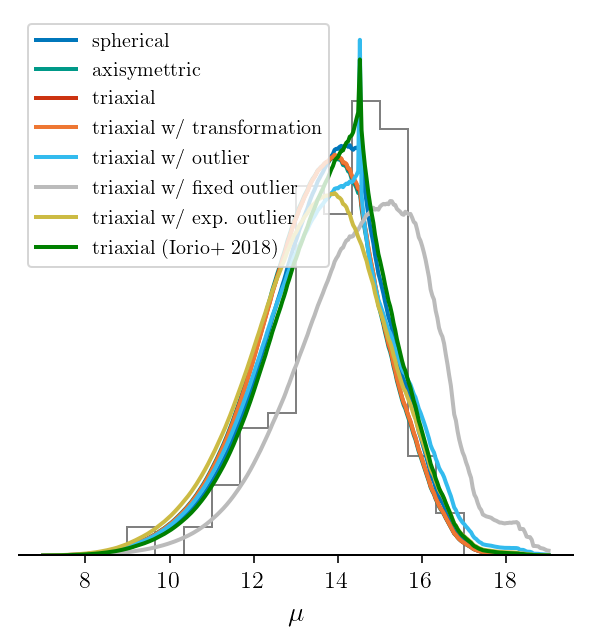

In [11]:
data_d = allstar['weighted_dist'][statIndx][accreted]/1e3
data_distmod = 5*np.log10(data_d*1e3)-5
model_names = ['spherical', 'axisymettric', 'triaxial', 'triaxial w/ transformation', r'triaxial w/ outlier', r'triaxial w/ fixed outlier',  r'triaxial w/ exp. outlier', r'triaxial (Iorio+ 2018)']
colours = ['#0077BB', '#009988', '#CC3311', '#EE7733', '#33BBEE', '#BBBBBB', '#CCBB44', 'Green']
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
for i in range(len(models)):
    locind = np.ones(len(outarea[goodfields]),dtype=bool)
    pd, pdt = pdistmod_model(models[i], opts[i], locind)
    plt.plot(distmods,pd, lw=2., color=colours[i], label=model_names[i])
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=18, color='gray', histtype='step')
ax = plt.gca()
plt.legend(loc=2)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.set_xlabel(r'$\mu$')

In [12]:
glonGlat = np.array([apo.glonGlat(loc) for loc in apo._locations]).reshape(667,2)


highb_togalcen = (np.fabs(glonGlat[goodfields][:,1]) > 10.) & ((glonGlat[goodfields][:,0] < 30.) | (glonGlat[goodfields][:,0] > 330.))
data_highb_to_galcen = (np.fabs(matched['GLAT']) > 10.) & ((matched['GLON'] < 30.) | (matched['GLON'] > 330.))

highb_awaygalcen = (np.fabs(glonGlat[goodfields][:,1]) > 10.) & (glonGlat[goodfields][:,0] > 150.) & (glonGlat[goodfields][:,0] < 210.)
data_highb_awaygalcen = (np.fabs(matched['GLAT']) > 10.) & (matched['GLON'] > 150.) & (matched['GLON'] < 210.)

lowb = (np.fabs(glonGlat[goodfields][:,1]) < 10.) 
data_lowb = (np.fabs(matched['GLAT']) < 10.) 

allfields = np.ones(len(glonGlat[goodfields]), dtype=bool)
data_allfields = np.ones(len(matched), dtype=bool)

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



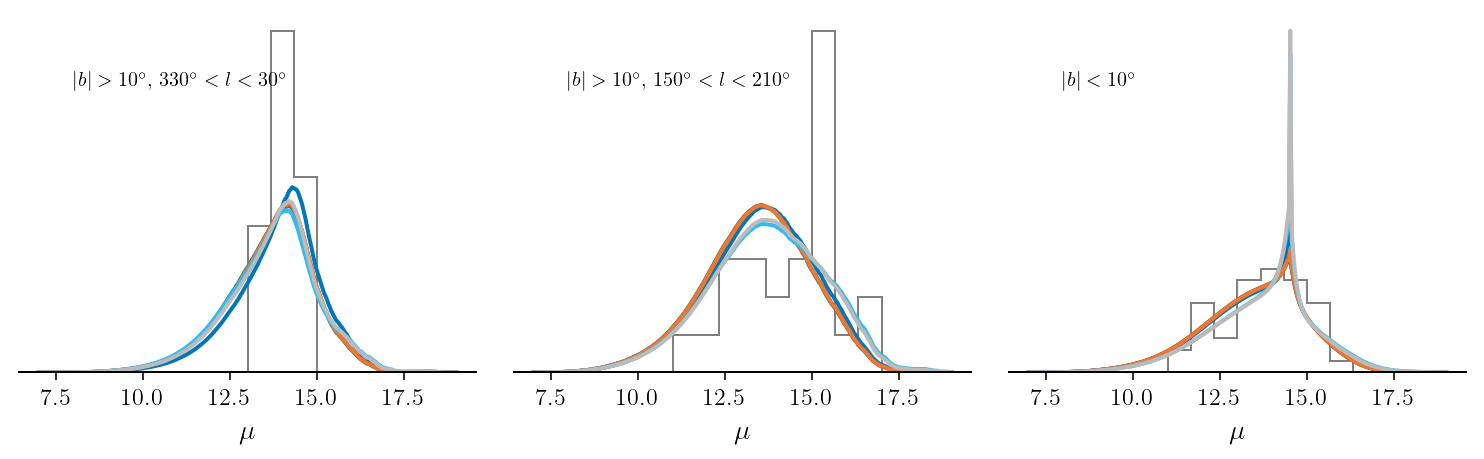

In [30]:

model_names = ['spherical', 'axisymettric', 'triaxial', 'triaxial w/ transformation', r'triaxial w/ outlier', r'triaxial w/ fixed outlier']
colours = ['#0077BB', '#009988', '#CC3311', '#EE7733', '#33BBEE', '#BBBBBB']
fieldsel_names = [r'$|b| > 10^{\circ}$, $330^{\circ} < l < 30^{\circ}$',
                  r'$|b| > 10^{\circ}$, $150^{\circ} < l < 210^{\circ}$',
                  r'$|b| < 10^{\circ}$']
indxs = [highb_togalcen, highb_awaygalcen, lowb]
datindxs = [data_highb_to_galcen, data_highb_awaygalcen, data_lowb]
fig, ax = plt.subplots(1,len(indxs))
fig.set_size_inches(1.5*textwidth,columnwidth)
for j in range(len(indxs)):
    for i in range(len(models)):
        locind = indxs[j]
        pd, pdt = pdistmod_model(models[i], opts[i], locind)
        ax[j].plot(distmods,pd, lw=2., color=colours[i], label=model_names[i])
    ax[j].hist(data_distmod[datindxs[j]], normed=True, range=[distmods[0],distmods[-1]], bins=18, color='gray', histtype='step')
    ax[j].axes.get_yaxis().set_visible(False)
    ax[j].set_frame_on(False)
    xmin, xmax = ax[j].get_xaxis().get_view_interval()
    ymin, ymax = ax[j].get_yaxis().get_view_interval()
    ax[j].add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
    ax[j].set_xlabel(r'$\mu$')
    ylims = ax[j].get_ylim()
    rang = ylims[1]-ylims[0]
    ax[j].text(8,ylims[1]-0.2*rang, fieldsel_names[j])
fig.tight_layout()

Text(0.5, 0, '$\\mu$')

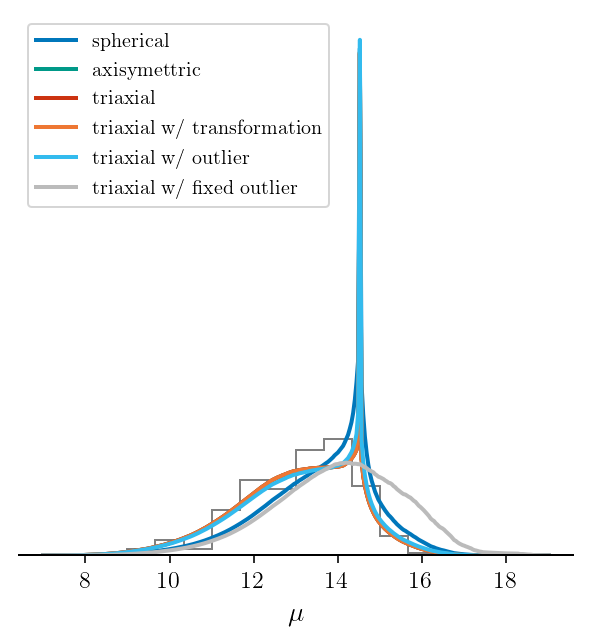

In [31]:
data_d = allstar['weighted_dist'][statIndx][control]/1e3
data_distmod = 5*np.log10(data_d*1e3)-5
model_names = ['spherical', 'axisymettric', 'triaxial', 'triaxial w/ transformation', r'triaxial w/ outlier', r'triaxial w/ fixed outlier']
colours = ['#0077BB', '#009988', '#CC3311', '#EE7733', '#33BBEE', '#BBBBBB']
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
for i in range(len(models)):
    locind = np.ones(len(outarea[goodfields]),dtype=bool)
    pd, pdt = pdistmod_model(models[i], copts[i], locind)
    plt.plot(distmods,pd, lw=2., color=colours[i], label=model_names[i])
plt.hist(data_distmod, normed=True, range=[distmods[0],distmods[-1]], bins=18, color='gray', histtype='step')
ax = plt.gca()
plt.legend(loc=2)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.set_xlabel(r'$\mu$')

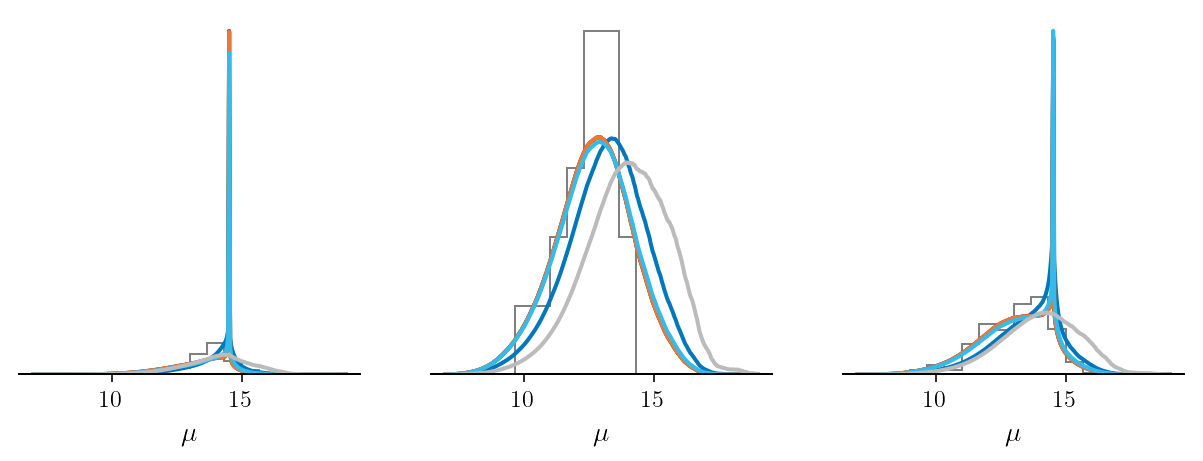

In [32]:
glonGlat = np.array([apo.glonGlat(loc) for loc in apo._locations]).reshape(667,2)


highb_togalcen = (np.fabs(glonGlat[goodfields][:,1]) > 10.) & (glonGlat[goodfields][:,0] < 30.) | (glonGlat[goodfields][:,0] > 330.)
data_highb_to_galcen = (np.fabs(cmatched['GLAT']) > 10.) & (cmatched['GLON'] < 30.) | (cmatched['GLON'] > 330.)

highb_awaygalcen = (np.fabs(glonGlat[goodfields][:,1]) > 10.) & (glonGlat[goodfields][:,0] > 150.) & (glonGlat[goodfields][:,0] < 210.)
data_highb_awaygalcen = (np.fabs(cmatched['GLAT']) > 10.) & (cmatched['GLON'] > 150.) & (cmatched['GLON'] < 210.)

allfields = np.ones(len(glonGlat[goodfields]), dtype=bool)
data_allfields = np.ones(len(cmatched), dtype=bool)

model_names = ['spherical', 'axisymettric', 'triaxial', 'triaxial w/ transformation', r'triaxial w/ outlier', r'triaxial w/ fixed outlier']
colours = ['#0077BB', '#009988', '#CC3311', '#EE7733', '#33BBEE', '#BBBBBB']
indxs = [highb_togalcen, highb_awaygalcen, allfields]
datindxs = [data_highb_to_galcen, data_highb_awaygalcen, data_allfields]
fig, ax = plt.subplots(1,len(indxs))
fig.set_size_inches(1.5*textwidth,columnwidth)
for j in range(len(indxs)):
    for i in range(len(models)):
        locind = indxs[j]
        pd, pdt = pdistmod_model(models[i], copts[i], locind)
        ax[j].plot(distmods,pd, lw=2., color=colours[i], label=model_names[i])
    ax[j].hist(data_distmod[datindxs[j]], normed=True, range=[distmods[0],distmods[-1]], bins=18, color='gray', histtype='step')
    ax[j].axes.get_yaxis().set_visible(False)
    ax[j].set_frame_on(False)
    xmin, xmax = ax[j].get_xaxis().get_view_interval()
    ymin, ymax = ax[j].get_yaxis().get_view_interval()
    ax[j].add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
    ax[j].set_xlabel(r'$\mu$')

In [16]:
copts, opts

([array([-1.54707031]),
  array([-1.69487893,  0.43286622]),
  array([-1.69449471,  0.99999949,  0.43283575]),
  array([-1.69566225e+00,  9.99999937e-01,  4.33033932e-01,  2.50621328e-03,
          2.99180542e-04]),
  array([-1.69582208,  0.99999996,  0.38571869, -1.60705529,  0.09157993]),
  array([-2.65518369e-09,  5.91796614e-08,  9.64384691e-01,  2.44577486e-02]),
  array([-1.68029880e+00,  9.99999202e-01,  4.68383645e-01,  1.89146485e-06]),
  array([2.78998634e+00, 9.42686782e-09, 6.35240444e+00, 9.99999881e-01,
         5.10454489e-01])],
 [array([-1.10830078]),
  array([-1.12065731,  0.72207116]),
  array([-1.11879915,  0.99999997,  0.7428162 ]),
  array([-1.11945981e+00,  9.99999847e-01,  7.48887311e-01,  3.99810039e-03,
          7.10263210e-09]),
  array([-1.46158873,  1.        ,  0.5814757 , -0.28376944,  0.00200403]),
  array([-5.59250074e-03,  4.08223838e-02,  2.34492135e-01,  4.95516187e-09]),
  array([-0.78654506,  0.99999999,  0.90602142,  0.06266147]),
  array([10.356

In [12]:
rs = np.linspace(0.,20.,100)
dens = utils.spherical(rs,np.zeros(len(rs)), np.zeros(len(rs)), params=opts[0])
cdens= utils.spherical(rs,np.zeros(len(rs)), np.zeros(len(rs)), params=copts[0])
idens = utils.triaxial_iorio(rs,np.zeros(len(rs)), np.zeros(len(rs)), params=opts[-1])

/Users/mackerje/Documents/gaia/enceladus-mass/py/utils.py:338: RuntimeWarning: divide by zero encountered in power
  dens = (x**2+y**2+z**2)**params[0]

/Users/mackerje/Documents/gaia/enceladus-mass/py/utils.py:421: RuntimeWarning: divide by zero encountered in power
  dens = (r_e/r_eb)**(-params[1])*(1+r_e/r_eb)**(-(params[2]-params[1]))



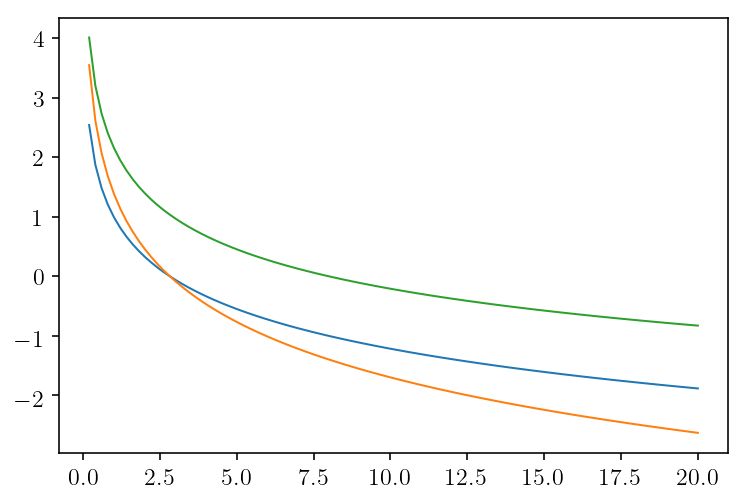

In [13]:
plt.plot(rs,np.log10(dens))
plt.plot(rs,np.log10(cdens))
plt.plot(rs,np.log10(idens))

In [12]:
for i in range(len(opts)):
    print(r'implied mass for '+model_names[i]+' model = 10^'+str(round(np.log10(implied_mass(models[i],opts[i])),2))+' M_sun$')
    
print(r'implied mass for contol sample, under '+model_names[-1]+' model = 10^'+str(round(np.log10(implied_mass(models[-1],copts[-1])),2))+' M_sun$')

implied mass for spherical model = 10^8.42 M_sun$
implied mass for axisymettric model = 10^8.37 M_sun$
implied mass for triaxial model = 10^8.37 M_sun$
implied mass for triaxial w/ transformation model = 10^8.37 M_sun$
implied mass for triaxial w/ outlier model = 10^9.3 M_sun$
implied mass for triaxial w/ fixed outlier model = 10^10.1 M_sun$
implied mass for triaxial w/ exp. outlier model = 10^8.71 M_sun$
implied mass for triaxial (Iorio et al. 2018) model = 10^8.53 M_sun$
implied mass for contol sample, under triaxial (Iorio et al. 2018) model = 10^8.02 M_sun$


In [41]:
ndim, nwalkers = 3, 200
pos = [opts[-2] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
nit = 500
threads = 8
effsel_in = outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields]

sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                    args=(utils.triaxial_norot, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), 
                                    threads=threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

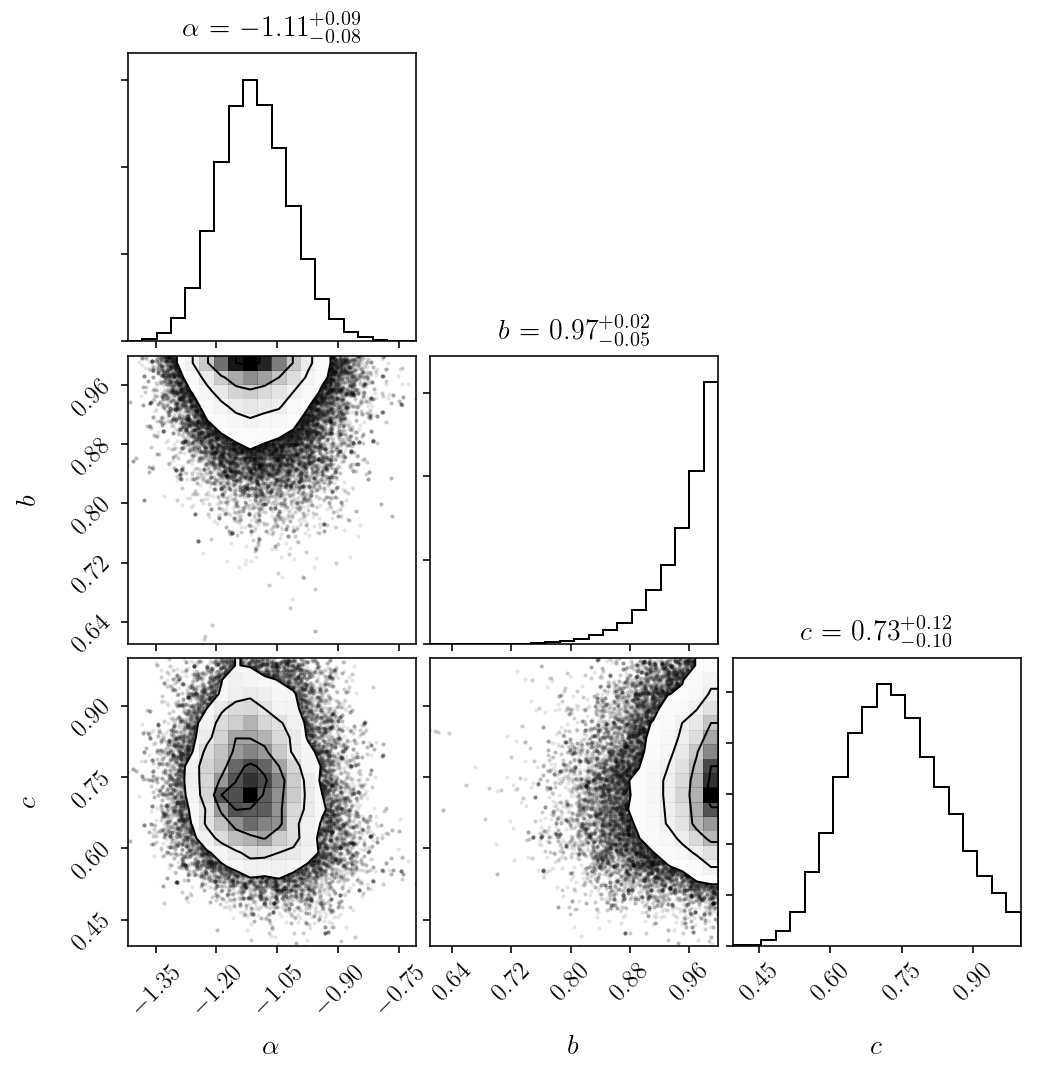

In [42]:
norot_samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
labels = [r'$\alpha$', r'$b$', r'$c$']
fig = corner.corner(norot_samples, labels=labels, show_titles=True)

In [14]:
ndim, nwalkers = 8, 200
pos = [opts[-1] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
nit = 500
threads = 8
effsel_in = outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields]

sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                    args=(utils.triaxialSP_iorio_qvar, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), 
                                    threads=threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

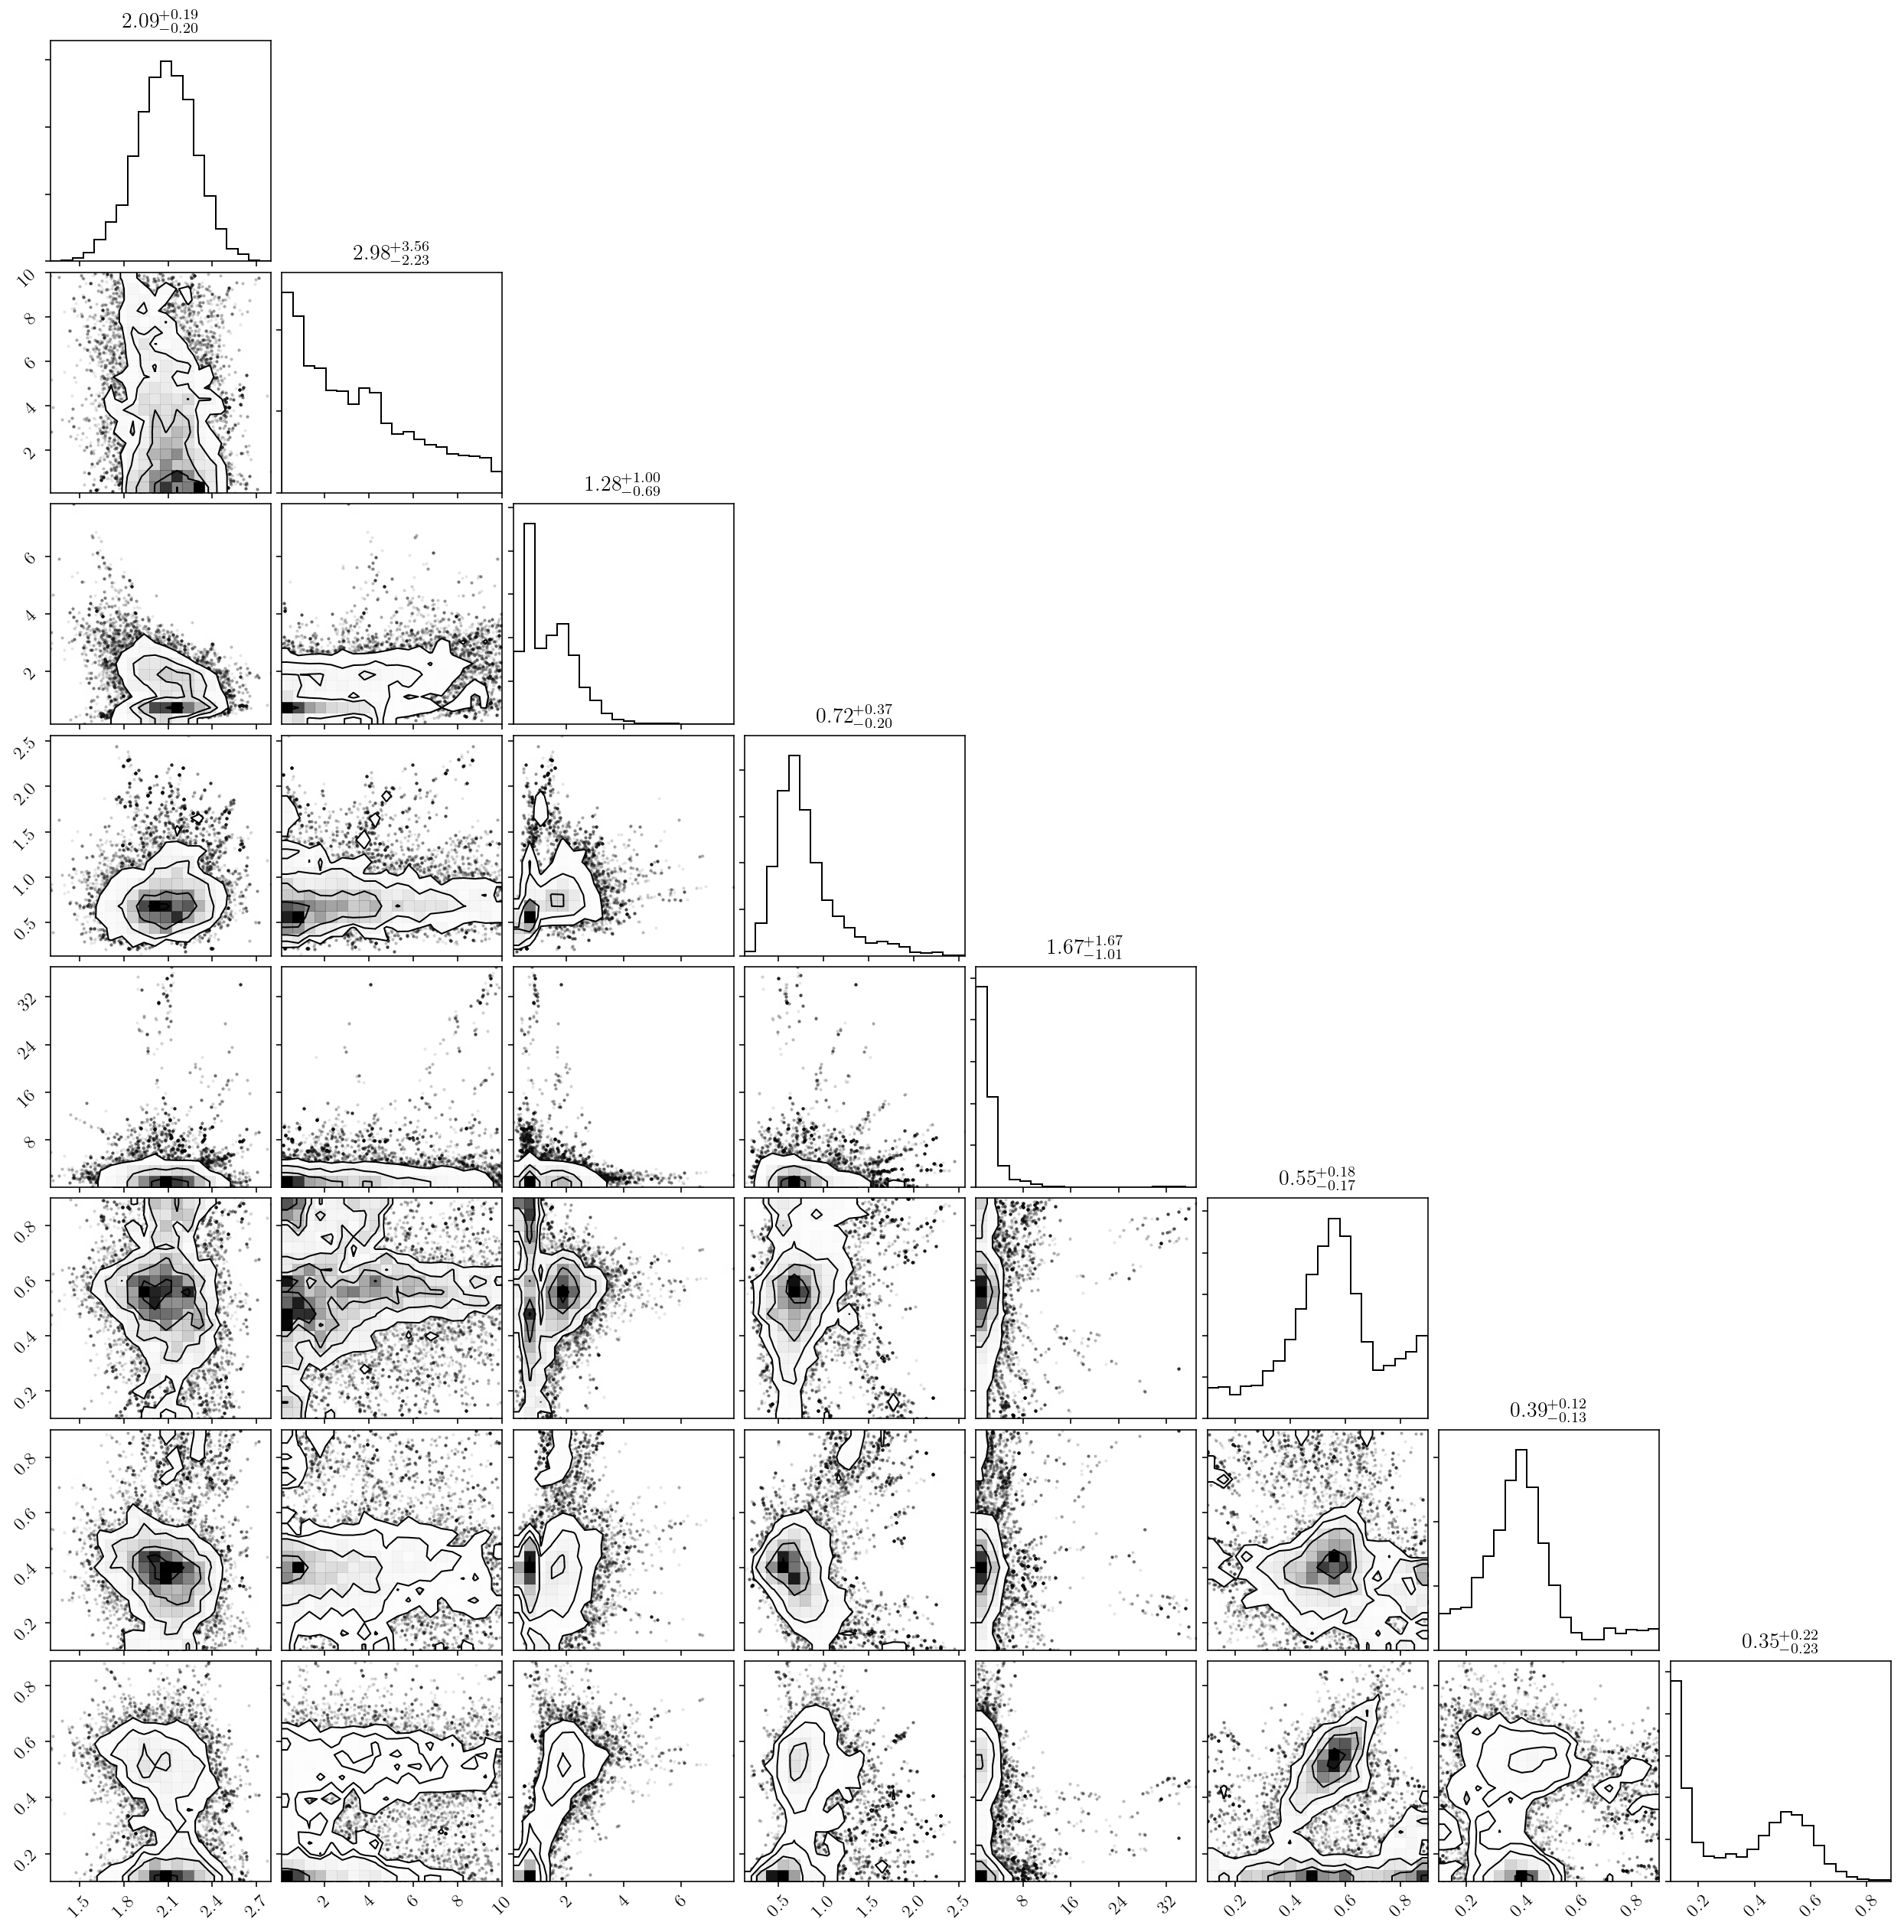

In [17]:
samples = sampler.chain[:, 300:, :].reshape((-1, ndim))
#labels = [r'$\alpha$', r'$b$', r'$c$', r'$\psi$', r'$\phi$', r'$\theta$']
fig = corner.corner(samples, show_titles=True)

In [114]:
ndim, nwalkers = 3, 200
pos = [copts[-2] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
nit = 500
threads = 8
effsel_in = outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields]

sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                    args=(utils.triaxial_norot, effsel_in, Rgrid_in, phigrid_in, zgrid_in, cRphiz[:,0], cRphiz[:,1], cRphiz[:,2]), 
                                    threads=threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

In [37]:
ndim, nwalkers = 4, 200
pos = [opts[-1] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
nit = 500
threads = 8
effsel_in = outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields]

sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                    args=(utils.triaxial_with_fixed_spherical_outlier, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), 
                                    threads=threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

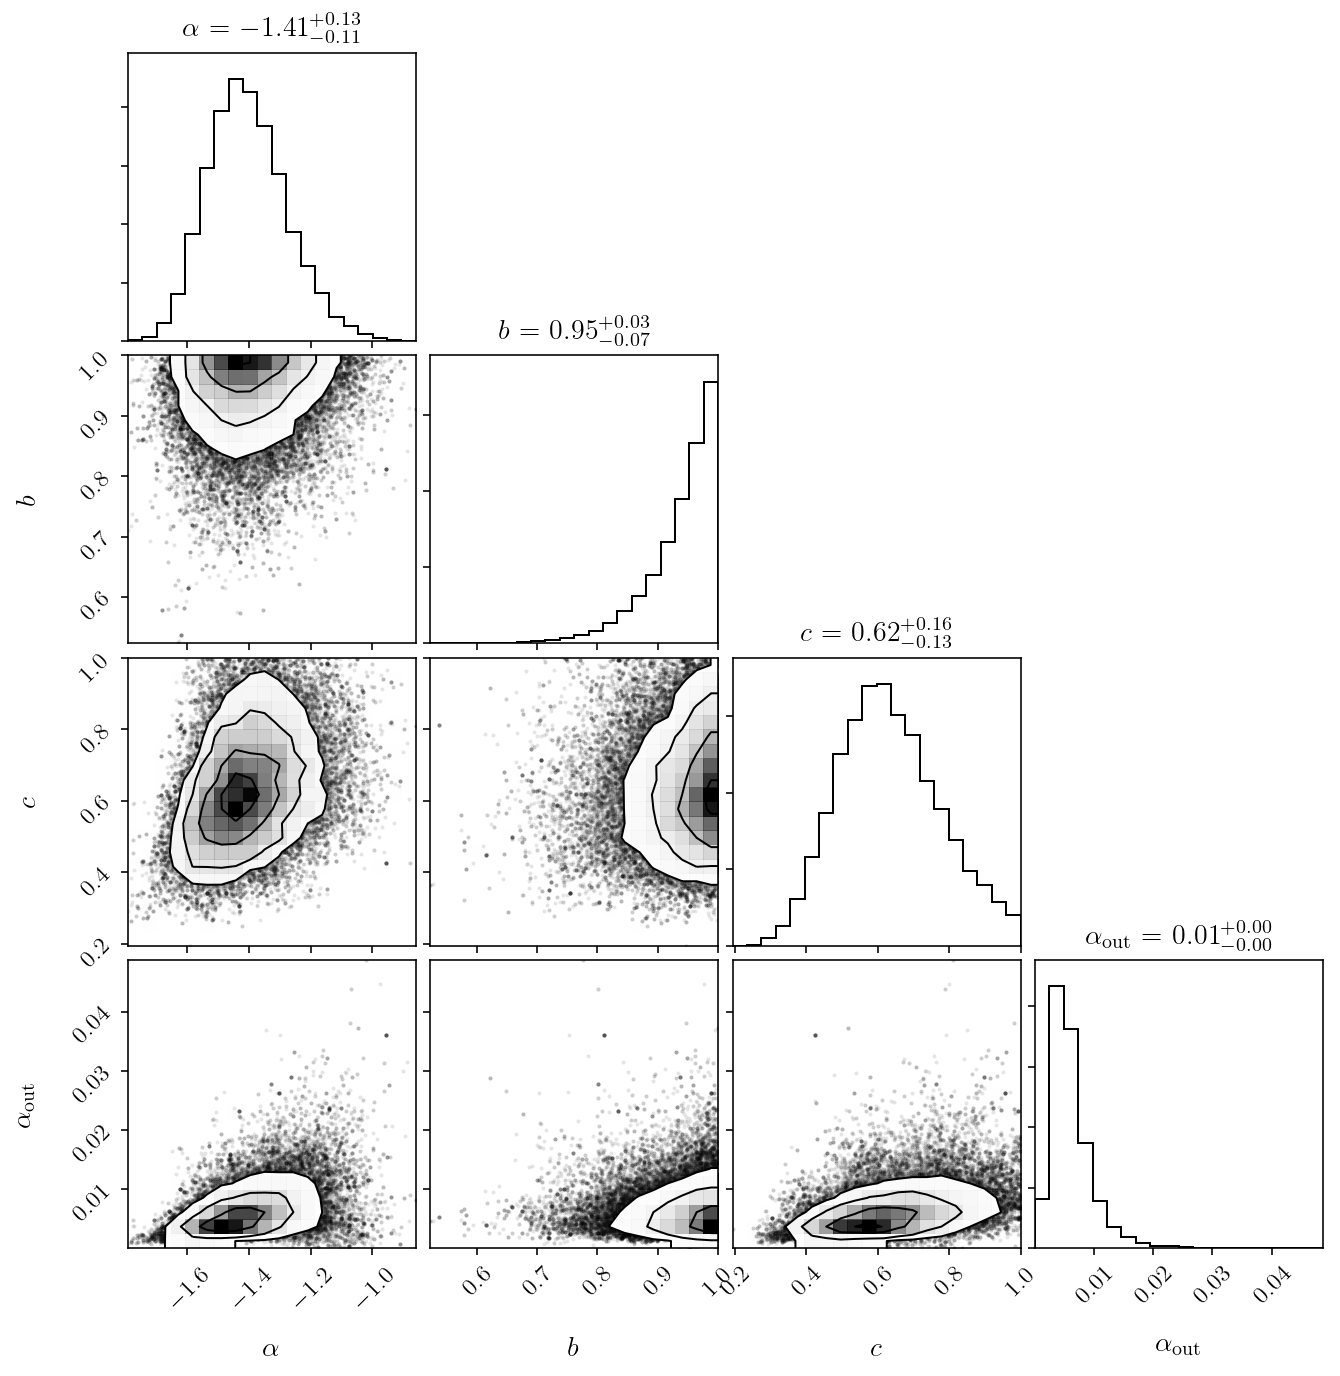

In [38]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
labels = [r'$\alpha$', r'$b$', r'$c$', r'$\alpha_{\mathrm{out}}$', r'$\epsilon$']
fig = corner.corner(samples, labels=labels, show_titles=True)

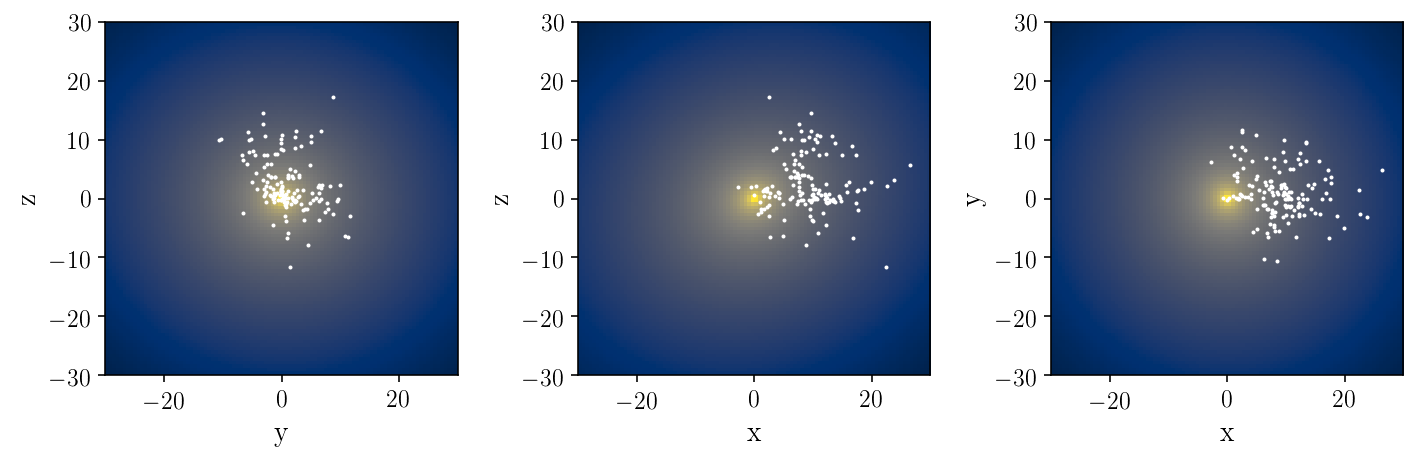

In [30]:
xyzgrid = np.mgrid[-30.:30.:100j,-30.:30.:100j,-30.:30.:100j]

shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(100,100,100,3).T

denstxyz = utils.triaxial(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=np.median(samples,axis=0))


fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,10)
ax[0].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=0))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)
ax[1].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=1))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)
ax[2].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=2))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)

xdat, ydat, zdat = bovy_coords.cyl_to_rect(Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
ax[0].scatter(ydat, zdat, s=1., color='White')
ax[1].scatter(xdat, zdat, s=1., color='White')
ax[2].scatter(xdat, ydat, s=1., color='White')

ax[0].set_xlabel(r'y')
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'z')
ax[2].set_xlabel(r'x')
ax[2].set_ylabel(r'y')

for axis in ax:
    axis.set_ylim(-30,30)
    axis.set_xlim(-30,30)
fig.tight_layout()

In [31]:
opts

[array([-1.10830078]),
 array([-1.12065731,  0.72207116]),
 array([-1.11879915,  0.99999997,  0.7428162 ]),
 array([-1.11945981e+00,  9.99999847e-01,  7.48887311e-01,  3.99810039e-03,
         7.10263210e-09])]

In [39]:
xyzgrid = np.mgrid[-100.:100.:150j,-100.:100.:150j,-100.:100.:150j]
delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3) & (trec['logg'] < 3) & (trec['logg'] > 1)
avmass = utils.average_mass(trec[isomask])
isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) #& (trec['J']-trec['K'] > 0.3) & (trec['logg'] < 3) & (trec['logg'] > 1)
massratio = utils.mass_ratio(trec[isomask])

print('number of giants relative to everything else: '+str(avmass/massratio))

number of giants relative to everything else: 154.47333222778468


In [49]:
shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(150,150,150,3).T
masses = np.zeros(400)
masses_norot = np.zeros(400)
for ii,params in tqdm.tqdm_notebook(enumerate(samples[np.random.randint(len(samples), size=400)]), total=400):
    rate = utils.triaxial(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=params)/utils.triaxial(8.,0.,0.02,params=params)*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
    sumrate = np.sum(rate)
    norm = len(Rphiz)/sumrate
    fac = norm*(180/np.pi)**2*avmass/massratio
    denstxyz = utils.triaxial(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params)/utils.triaxial(8.,0.,0.02, params=params)*fac
    masses[ii] =  np.sum(denstxyz)*(delta*delta*delta)
    norotparams = norot_samples[np.random.randint(len(norot_samples))]
    rate = utils.triaxial_norot(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=norotparams)/utils.triaxial_norot(8.,0.,0.02,params=norotparams)*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
    sumrate = np.sum(rate)
    norm = len(Rphiz)/sumrate
    fac = norm*(180/np.pi)**2*avmass/massratio
    denstxyz = utils.triaxial_norot(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=norotparams)/utils.triaxial_norot(8.,0.,0.02, params=norotparams)*fac
    masses_norot[ii] =  np.sum(denstxyz)*(delta*delta*delta)

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

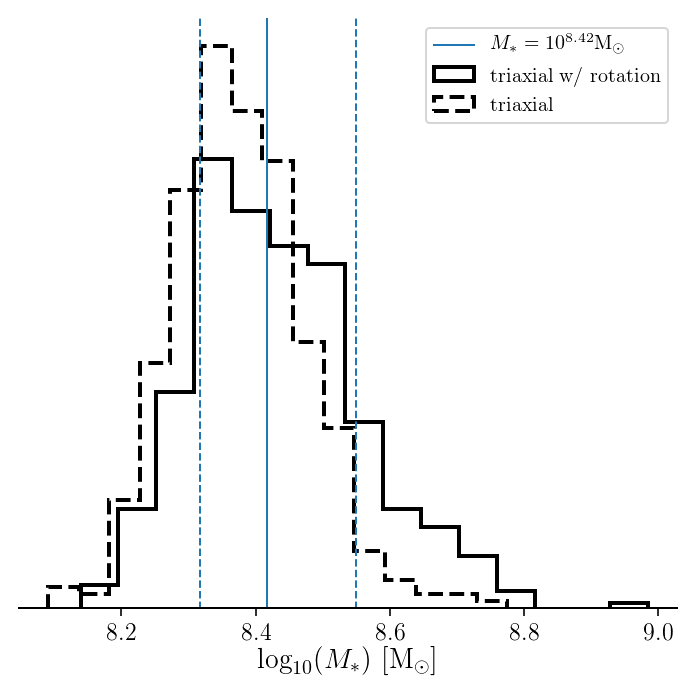

In [117]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
plt.hist(np.log10(masses), histtype='step', lw=2., color='Black', density=True, bins=15, label=r'triaxial w/ rotation')
plt.hist(np.log10(masses_norot), histtype='step', lw=2., color='Black', linestyle='dashed', density=True, bins=15,label=r'triaxial')
plt.axvline(np.log10(np.median(masses)), label=r'$M_* = 10^{'+str(round(np.log10(np.median(masses)),2))+r'}\mathrm{M_{\odot}}$')
plt.axvline(np.log10(np.percentile(masses, 16)), linestyle='dashed')
plt.axvline(np.log10(np.percentile(masses, 84)), linestyle='dashed')

plt.xlabel(r'$\log_{10}(M_*)\ \mathrm{[M_{\odot}]}$')
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
plt.legend()
fig.tight_layout()

In [56]:
(10**8.6)/(10**8)

3.981071705534969

In [ ]:
plt.scatter(allstar[statIndx]['J0']-allstar[statIndx]['K0'], allstar[statIndx]['H0']-(5*np.log10(allstar[statIndx]['weighted_dist'])-5), s=0.01,lw=0., color='Black')
plt.scatter(matched['J0']-matched['K0'], matched['H0']-(5*np.log10(matched['weighted_dist'])-5), s=1)
plt.ylim(10,-10)
plt.xlim(-0.3,1.5)

In [ ]:
plt.scatter(allstar[statIndx]['TEFF'], allstar[statIndx]['LOGG'], s=0.01,lw=0., color='Black')
plt.scatter(matched['TEFF'], matched['LOGG'], s=1)
plt.xlim(5500,3500)
plt.ylim(4,-1.)

In [145]:
#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(outarea < 1e-9, axis=1)
# setup the grid in Rphiz where the effective selection function is evaluated
Rgrid, phigrid, zgrid = utils.Rphizgrid(apo, distmods)
# setup a list of models to fit and their initial parameter guesses.
fehbins = np.arange(-1.5,-0.9,0.1)
print(fehbins)

[-1.5 -1.4 -1.3 -1.2 -1.1 -1. ]


In [168]:
models = [utils.spherical, utils.axisymmetric, utils.triaxial_norot, utils.triaxial]
model_names = ['spherical', 'axisymettric', 'triaxial', 'triaxial w/ transformation']
inits = [[-2.,], [-2.,0.99], [-2.,0.99,0.99], [-2.,0.99,0.99,0.,0.]] 
cbinopts = []
binopts = []
for ib in range(len(fehbins)-1):
    mask = (allstar[statIndx]['LOGG'] < 3.) &\
           (allstar[statIndx]['LOGG'] > 1.) &\
           (allstar[statIndx]['FE_H'] > fehbins[ib]) &\
           (allstar[statIndx]['FE_H'] < fehbins[ib+1]) &\
           (allstar[statIndx]['MG_FE'] < 0.5) &\
           (allstar[statIndx]['MG_FE'] > 0.25)
    tXYZ, tRphiz = allstar_to_coords(allstar[statIndx][mask])
    print(len(tRphiz))
    # do the MLE fits
    print('Fitting '+model_names[2]+' model...')
    print('control sample:')
    opt = op.fmin(lambda x: utils.mloglike(x,models[2], outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], tRphiz[:,0], tRphiz[:,1], tRphiz[:,2]), inits[2], full_output=True)
    cbinopts.append(opt[0])
    print(opt)
    mask = (allstar[statIndx]['LOGG'] < 3.) &\
           (allstar[statIndx]['LOGG'] > 1.) &\
           (allstar[statIndx]['FE_H'] > fehbins[ib]) &\
           (allstar[statIndx]['FE_H'] < fehbins[ib+1]) &\
           (allstar[statIndx]['MG_FE'] < 0.2) &\
           (allstar[statIndx]['MG_FE'] > 0.)
    tXYZ, tRphiz = allstar_to_coords(allstar[statIndx][mask])
    print(len(tRphiz))
    # do the MLE fits
    print('Fitting '+model_names[2]+' model...')
    print('enceladus sample:')
    opt = op.fmin(lambda x: utils.mloglike(x,models[2], outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], tRphiz[:,0], tRphiz[:,1], tRphiz[:,2]), inits[2], full_output=True)
    binopts.append(opt[0])
    print(opt)
    
        
    

34
Fitting triaxial model...
control sample:
Optimization terminated successfully.
         Current function value: 297.359467
         Iterations: 280
         Function evaluations: 502
(array([-1.62400579,  0.99999975,  0.59646303]), 297.359466649325, 280, 502, 0)
23
Fitting triaxial model...
enceladus sample:
Optimization terminated successfully.
         Current function value: 235.510816
         Iterations: 173
         Function evaluations: 326
(array([-1.1956833 ,  0.99999998,  0.9960787 ]), 235.51081557360388, 173, 326, 0)
32
Fitting triaxial model...
control sample:
Optimization terminated successfully.
         Current function value: 282.300967
         Iterations: 140
         Function evaluations: 257
(array([-1.606228  ,  0.99999997,  0.63770785]), 282.3009669097458, 140, 257, 0)
39
Fitting triaxial model...
enceladus sample:
Optimization terminated successfully.
         Current function value: 399.334770
         Iterations: 112
         Function evaluations: 209
(arra

In [169]:
opt = np.array(binopts)
copt = np.array(cbinopts)

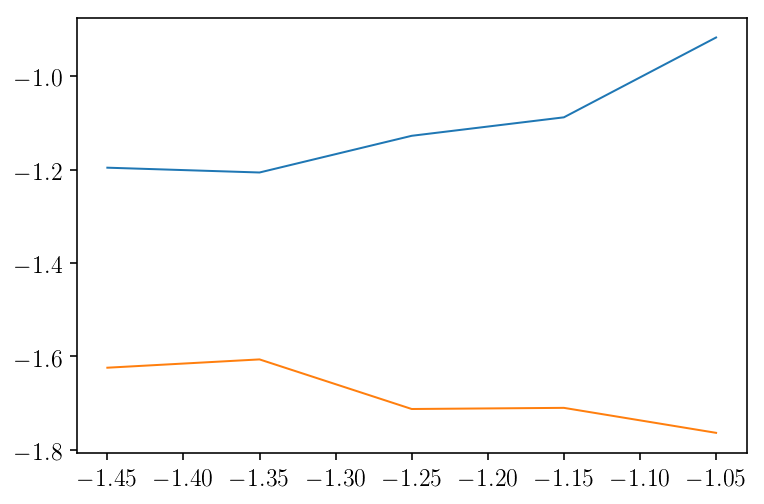

In [172]:
bcs = (fehbins[:-1]+fehbins[1:])/2.
plt.plot(bcs, opt[:,0])
plt.plot(bcs, copt[:,0])

In [166]:
ms = []
cms = []
for i in range(len(triaxialo)):
    ms.append(np.log10(implied_mass(models[2],triaxialo[i])))
    cms.append(np.log10(implied_mass(models[2],triaxialo[i])))
    

implied mass for triaxial model = 10^8.04 M_sun$
implied mass for triaxial model = 10^8.05 M_sun$
implied mass for triaxial model = 10^7.99 M_sun$
implied mass for triaxial model = 10^7.97 M_sun$
implied mass for triaxial model = 10^7.95 M_sun$


In [65]:
def mle_fit(Rphiz, model, init,locmask):
    opt = op.fmin(lambda x: utils.mloglike(x,model, outarea[goodfields][locmask]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields][locmask], phigrid[goodfields][locmask], zgrid[goodfields][locmask], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), init, full_output=True)
    return opt
    
def sample(Rphiz, model,opt,locmask,nwalkers=200,nit=500,threads=8):
    ndim = len(opt)
    pos = np.array([opt + 1e-3*np.random.randn(ndim) for i in range(nwalkers)])
    pos[:,3] = np.fabs(pos[:,3])
    effsel_in = outarea[goodfields][locmask]*ds**2.*(distmods[1]-distmods[0])
    Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodfields][locmask], phigrid[goodfields][locmask], zgrid[goodfields][locmask]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                        args=(model, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), 
                                        threads=threads)
    for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
        continue
    return sampler

def sample_mass(Rphiz, model, samples, avmass, massratio, datamask, locmask):
    xyzgrid = np.mgrid[-100.:100.:150j,-100.:100.:150j,-100.:100.:150j]
    delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
    shape = np.shape(xyzgrid.T)
    xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
    rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
    rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    rphizgrid = rphizgrid.reshape(150,150,150,3).T
    masses = np.zeros(400)
    for ii,params in tqdm.tqdm_notebook(enumerate(samples[np.random.randint(len(samples), size=400)]), total=400):
        rate = model(Rgrid[goodfields][locmask],phigrid[goodfields][locmask],zgrid[goodfields][locmask],params=params)/model(8.,0.,0.02,params=params)*outarea[goodfields][locmask]*ds**2.*(distmods[1]-distmods[0])
        sumrate = np.sum(rate)
        norm = len(Rphiz)/sumrate
        fac = norm*(180/np.pi)**2*avmass/massratio
        denstxyz = model(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params)/model(8.,0.,0.02, params=params)*fac
        masses[ii] =  np.sum(denstxyz)*(delta*delta*delta)
    return masses

In [11]:
isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3) & (trec['logg'] < 3) & (trec['logg'] > 1)
avmass = utils.average_mass(trec[isomask])
isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) #& (trec['J']-trec['K'] > 0.3) & (trec['logg'] < 3) & (trec['logg'] > 1)
massratio = utils.mass_ratio(trec[isomask])

print('number of giants relative to everything else: '+str(avmass/massratio))

number of giants relative to everything else: 154.47333222778468


In [12]:
glonglat = np.array([apo.glonGlat(loc) for loc in apo._locations[goodfields]])
glonglat = glonglat.reshape((len(glonglat),2))

In [13]:
allIndx = np.ones(len(glonglat), dtype=bool)
highbIndx = (np.fabs(glonglat[:,1]) > 10.)
base_mask = (allstar[statIndx]['LOGG'] < 3.) &\
       (allstar[statIndx]['LOGG'] > 1.) &\
       (allstar[statIndx]['FE_H'] > -1.3) &\
       (allstar[statIndx]['FE_H'] < -1.) &\
       (allstar[statIndx]['MG_FE'] < 0.2) &\
       (allstar[statIndx]['MG_FE'] > 0.)
control_mask = (allstar[statIndx]['LOGG'] < 3.) &\
       (allstar[statIndx]['LOGG'] > 1.) &\
       (allstar[statIndx]['FE_H'] > -1.3) &\
       (allstar[statIndx]['FE_H'] < -1.) &\
       (allstar[statIndx]['MG_FE'] < 0.5) &\
       (allstar[statIndx]['MG_FE'] > 0.25)

datahighb = base_mask & (np.fabs(allstar[statIndx]['GLAT']) > 10.)
cdatahighb = control_mask & (np.fabs(allstar[statIndx]['GLAT']) > 10.)
model = utils.triaxial_norot
init = [-1.,0.5,0.5,0.1]

locmasks = [allIndx, highbIndx, allIndx, highbIndx]
datmasks = [base_mask, datahighb, control_mask, cdatahighb]

all_samples = []
all_masses = []
for i in range(len(locmasks)):
    datamask = datmasks[i]
    tXYZ, tRphiz = allstar_to_coords(allstar[statIndx][datamask])
    locmask = locmasks[i]
    opt = mle_fit(tRphiz, model, init, locmask)
    print(opt[0])
    sampler = sample(tRphiz, model, opt[0], locmask)
    ndim = len(opt[0])
    samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
    masses = sample_mass(tRphiz, model, samples, avmass, massratio, datamask, locmask)
    all_samples.append(samples)
    all_masses.append(masses)

Optimization terminated successfully.
         Current function value: 912.057502
         Iterations: 139
         Function evaluations: 245
[-1.03818721  0.99999994  0.48490028  0.04206983]



Optimization terminated successfully.
         Current function value: 616.074315
         Iterations: 183
         Function evaluations: 320
[-1.02878097  0.99999998  0.66986573  0.04327982]



Optimization terminated successfully.
         Current function value: 1507.772625
         Iterations: 155
         Function evaluations: 266
[-1.72988047  0.99999865  0.37544901  0.00799477]



Optimization terminated successfully.
         Current function value: 1027.596935
         Iterations: 143
         Function evaluations: 255
[-2.47261033  0.99999976  0.43854025  0.02902247]


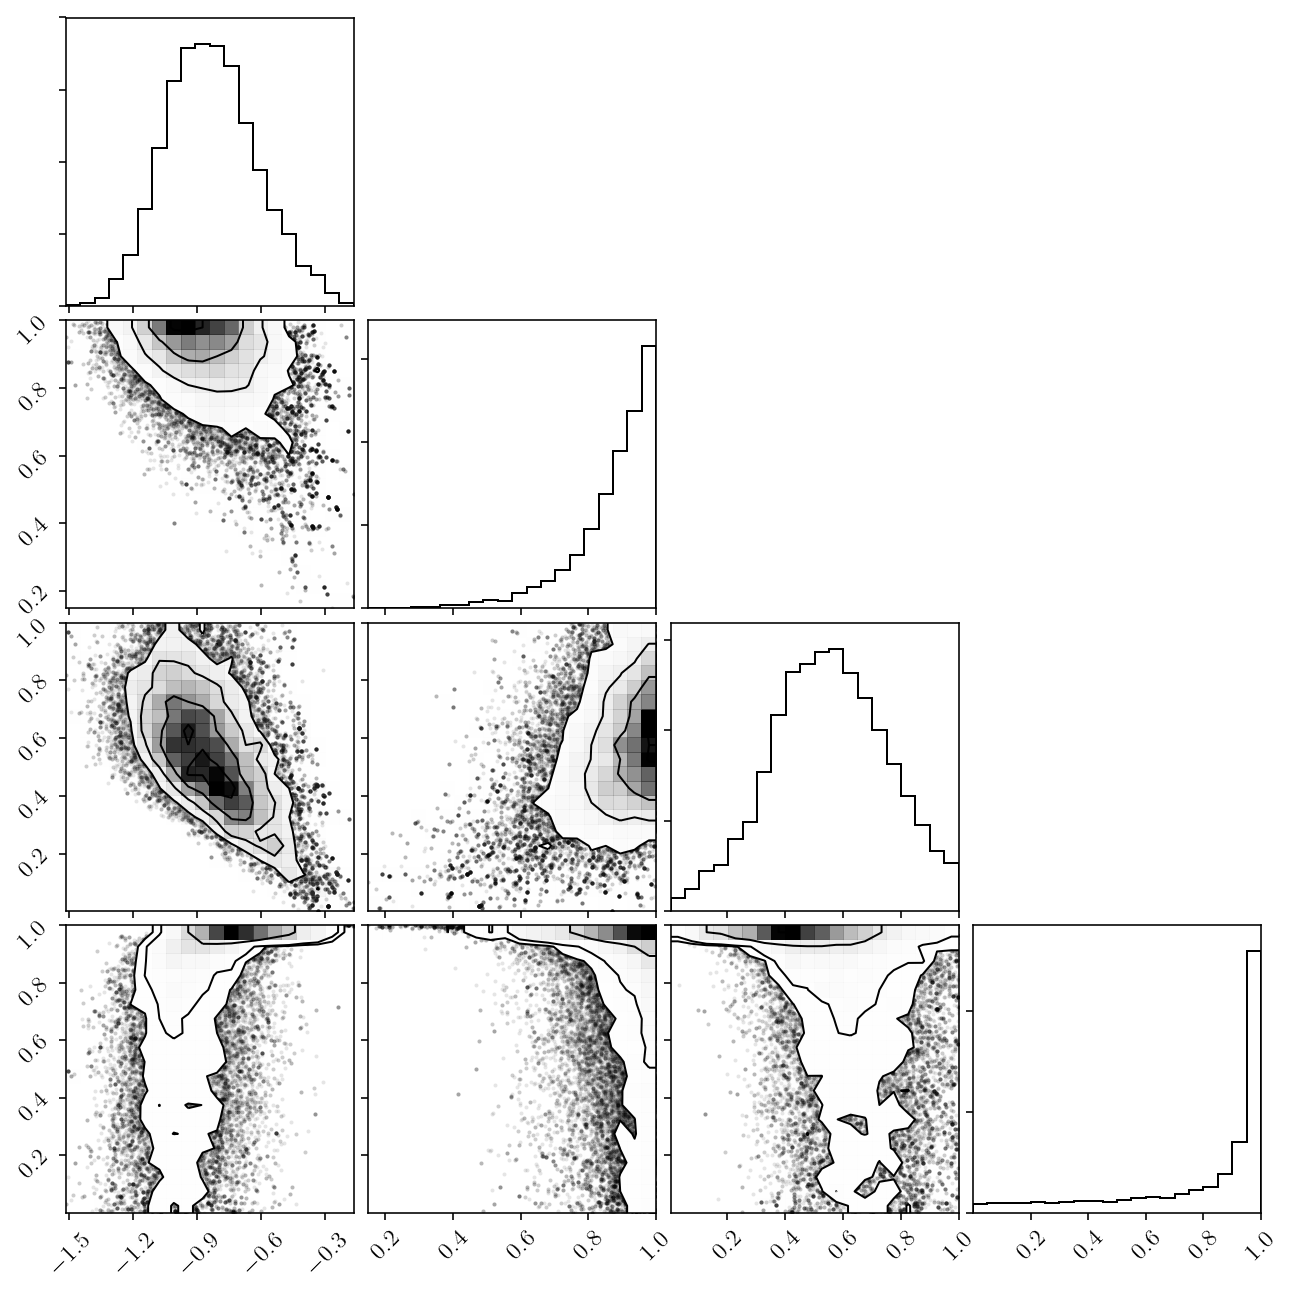

In [49]:
fig = corner.corner(all_samples[1])

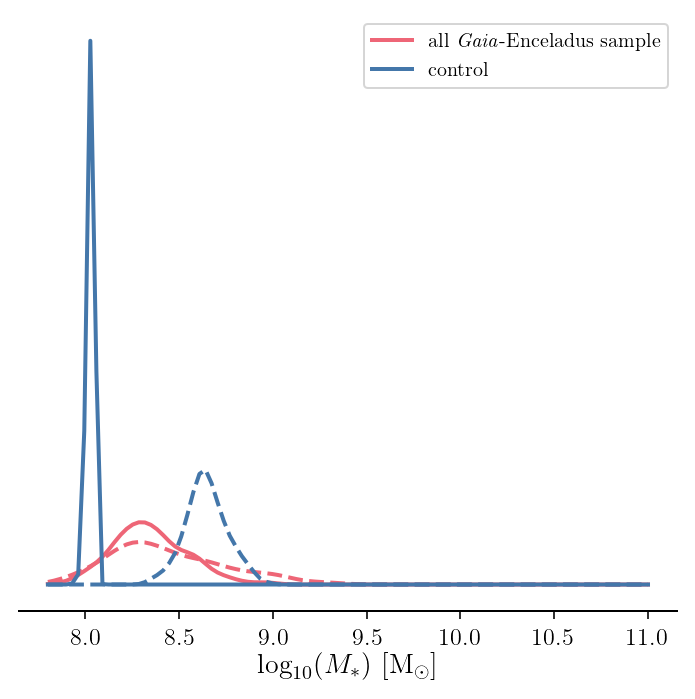

In [50]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)

bins = np.linspace(7.8,11,100)
kde = gaussian_kde(np.log10(all_masses[0])[np.isfinite(np.log10(all_masses[0]))])
plt.plot(bins,kde(bins), lw=2., color='#EE6677', label=r'all \emph{Gaia}-Enceladus sample')
kde = gaussian_kde(np.log10(all_masses[1])[np.isfinite(np.log10(all_masses[1]))])
plt.plot(bins,kde(bins), lw=2., color='#EE6677', linestyle='dashed')
kde = gaussian_kde(np.log10(all_masses[2])[np.isfinite(np.log10(all_masses[2]))])
plt.plot(bins,kde(bins), lw=2., color='#4477AA', label=r'control')
kde = gaussian_kde(np.log10(all_masses[3])[np.isfinite(np.log10(all_masses[3]))])
plt.plot(bins,kde(bins), lw=2., color='#4477AA', linestyle='dashed')
#plt.axvline(np.log10(np.median(all_masses[0])), label=r'$M_* = 10^{'+str(round(np.log10(np.median(masses)),2))+r'}\mathrm{M_{\odot}}$')
#plt.axvline(np.log10(np.percentile(all_masses[0], 16)), linestyle='dashed')
#plt.axvline(np.log10(np.percentile(all_masses[0], 84)), linestyle='dashed')

plt.xlabel(r'$\log_{10}(M_*)\ \mathrm{[M_{\odot}]}$')
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
plt.legend()
fig.tight_layout()

plt.savefig('../plots/mass-posterior.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/mass-posterior.png', format='png', dpi=400, bbox_inches='tight')

No handles with labels found to put in legend.


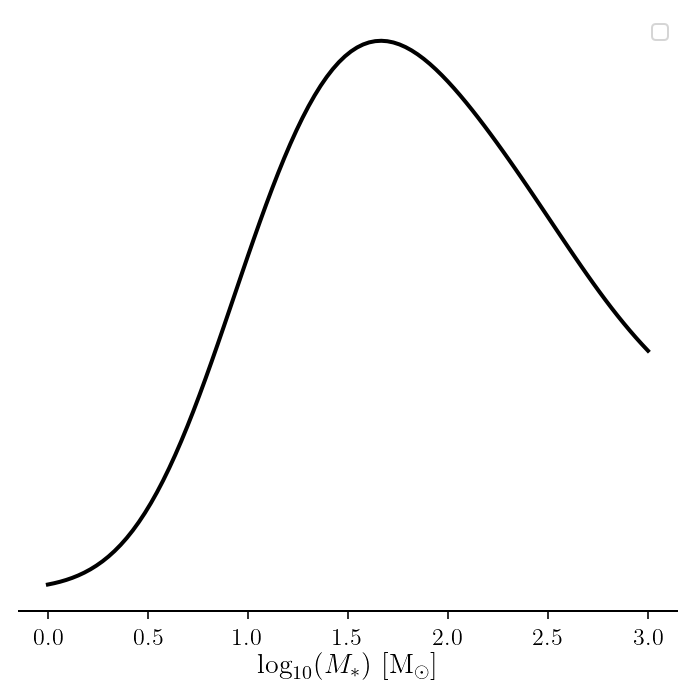

In [46]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)

bins = np.linspace(0.,3.,100)
kde = gaussian_kde(all_masses[0]/all_masses[2])
plt.plot(bins,kde(bins), lw=2., color='Black')



plt.xlabel(r'$\log_{10}(M_*)\ \mathrm{[M_{\odot}]}$')
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
plt.legend()
fig.tight_layout()

In [51]:
np.median(all_masses[0])/np.median(all_masses[2])

1.4666905203747331

In [131]:
def implied_mass(Rphiz, densfunc,params, justmain = False):
    isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3) & (trec['logg'] < 3) & (trec['logg'] > 1)
    avmass = utils.average_mass(trec[isomask])
    isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) #& (trec['J']-trec['K'] > 0.3) & (trec['logg'] < 3) & (trec['logg'] > 1)
    massratio = utils.mass_ratio(trec[isomask])
    xyzgrid = np.mgrid[-100.:100.:150j,-100.:100.:150j,-100.:100.:150j]
    delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
    shape = np.shape(xyzgrid.T)
    xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
    rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
    rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    rphizgrid = rphizgrid.reshape(150,150,150,3).T
    rate = densfunc(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=params)*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
    sumrate = np.sum(rate)
    norm = len(Rphiz)/sumrate
    fac = norm*(180/np.pi)**2*avmass/massratio
    print(fac)
    print(avmass/massratio)
    print(norm)
    print(sumrate)
    if justmain:
        denstxyz = densfunc(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params, just_main=justmain)*fac
    else:
        denstxyz = densfunc(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params)*fac
    print(np.sum(densfunc(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params)))
    print(np.sum(densfunc(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params, just_main=True)))
    print(np.sum(densfunc(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params, just_outlier=True)))
    return np.sum(denstxyz)*(delta*delta*delta)

In [132]:
datamask = datmasks[0]
tXYZ, tRphiz = allstar_to_coords(allstar[statIndx][datamask])
np.log10(implied_mass(tRphiz, triaxial_with_fixed_spherical_outlier, np.median(all_samples[0], axis=0), justmain=True))

2748.5104663411275
154.47333222778468
0.005419991622107344
27675.319531523295
387692.84717175603
1993.7994947377533
21232.793019352175


7.1223100584603625

NameError: name 'fac' is not defined

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in power



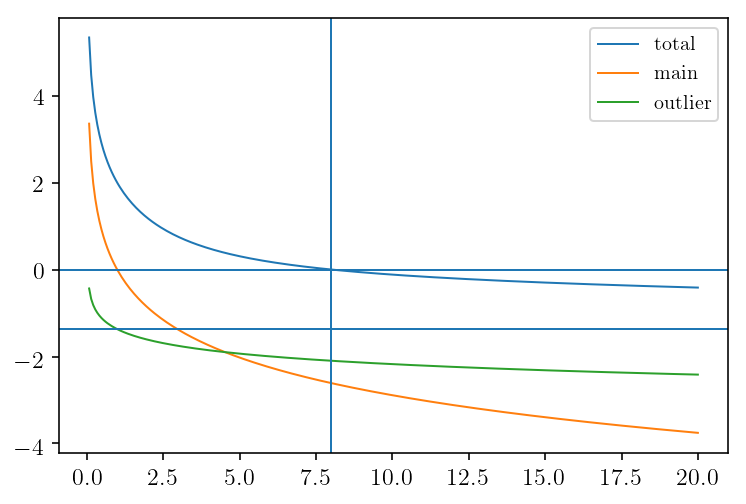

In [133]:
def triaxial_with_fixed_spherical_outlier(R,phi,z,params=[2.5,1.,1.,0.1], just_main=False, just_outlier=False):
    """
    general triaxial power-law density model with some rotation about the center of the ellipsoid
    INPUT
        R, phi, z - Galactocentric cylindrical coordinates
        params - [alpha, b, c, alpha_outlier, epsilon]
    OUTPUT
        density at R, phi, z (no normalisation!)
    """
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    xyz = np.dstack([x,y,z])[0]
    dens = (x**2+y**2/params[1]**2+z**2/params[2]**2)**params[0]
    outdens = (x**2+y**2+z**2)**-0.4
    sundens = (1-params[3])*((8.**2+0.02**2/params[2]**2)**params[0])+params[3]*((8.**2+0.02**2)**-0.4)
    if just_main:
        dens = (1-params[3])*dens
    elif just_outlier:
        dens = params[3]*outdens
    else:
        dens = ((1-params[3])*dens+params[3]*outdens)/sundens
    if grid:
        dens = dens.reshape(dim)
    return dens


rs = np.linspace(0.,20.,300)
phis = np.zeros(300)
zs = np.zeros(300)
dens_sun = triaxial_with_fixed_spherical_outlier(8.,0.,0.02, params=np.median(all_samples[0], axis=0))
plt.plot(rs, np.log10(triaxial_with_fixed_spherical_outlier(rs,phis,zs, params=np.median(all_samples[0], axis=0))), label='total')
plt.plot(rs,np.log10(triaxial_with_fixed_spherical_outlier(rs,phis,zs, params=np.median(all_samples[0], axis=0), just_main=True)), label='main')
plt.plot(rs,np.log10(triaxial_with_fixed_spherical_outlier(rs,phis,zs, params=np.median(all_samples[0], axis=0), just_outlier=True)), label='outlier')
plt.axhline(np.log10(np.median(all_samples[0], axis=0)[3]))
plt.axhline(np.log10(1-np.median(all_samples[0], axis=0)[3]))
plt.axhline(np.log10(1.))
plt.axvline(8.)
plt.legend()


In [89]:
1-np.median(all_samples[0], axis=0)[3]

0.9578436255656663

In [58]:
from galpy.util import bovy_conversion

In [68]:
1.4*bovy_conversion.freq_in_Gyr(220.,8.), 1.4*bovy_conversion.freq_in_kmskpc(220.,8.)

(39.374418354567744, 38.5)

In [72]:
((40*(2*np.pi))*(30000/1e9))*(180/np.pi)

0.432

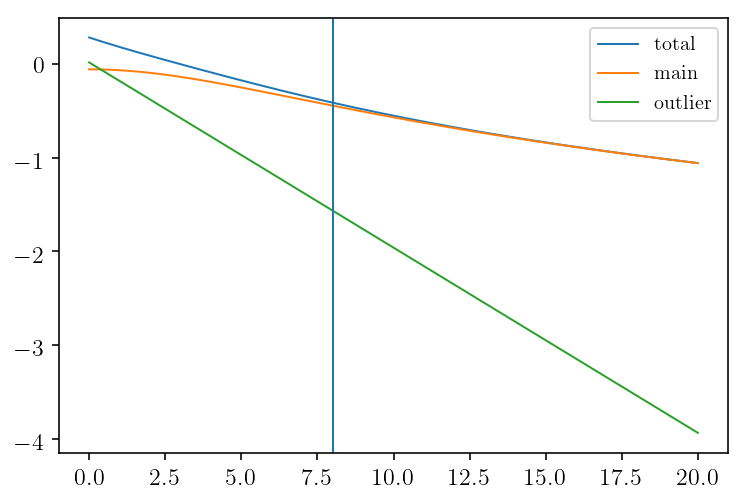

In [34]:
def triaxial_with_expdisk_outlier(R,phi,z,params=[2.5,1.,1.,0.1], just_main=False, just_outlier=False):
    """
    general triaxial power-law density model with some rotation about the center of the ellipsoid
    INPUT
        R, phi, z - Galactocentric cylindrical coordinates
        params - [alpha, b, c, alpha_outlier, epsilon]
    OUTPUT
        density at R, phi, z (no normalisation!)
    """
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    xyz = np.dstack([x,y,z])[0]
    dens = (1-params[3])*((x**2+y**2/params[1]**2+z**2/params[2]**2)**params[0])/((1-params[3])*((8.**2+0.02**2/params[2]**2)**params[0])+params[3])
    outdens = params[3]*np.exp(-1*(R-8.)/2.2-np.fabs(z)/1.5)/((1-params[3])*((8.**2+0.02**2/params[2]**2)**params[0])+params[3])
    #sundens = (1-params[3])*((8.**2+0.02**2/params[2]**2)**params[0])+params[3]*((8.**2+0.02**2)**-0.4)
    if just_main:
        dens = dens
    elif just_outlier:
        dens = outdens
    else:
        dens = dens+outdens
    if grid:
        dens = dens.reshape(dim)
    return dens


rs = np.linspace(0.,20.,300)
phis = np.zeros(300)
zs = np.ones(300)*4.
tpar = [-1.,1.,0.6,0.01]
dens_sun = triaxial_with_expdisk_outlier(8.,0.,0.02, params=tpar)
plt.plot(rs, np.log10(triaxial_with_expdisk_outlier(rs,phis,zs, params=tpar)), label='total')
plt.plot(rs,np.log10(triaxial_with_expdisk_outlier(rs,phis,zs, params=tpar, just_main=True)), label='main')
plt.plot(rs,np.log10(triaxial_with_expdisk_outlier(rs,phis,zs, params=tpar, just_outlier=True)), label='outlier')


plt.axvline(8.)
plt.legend()

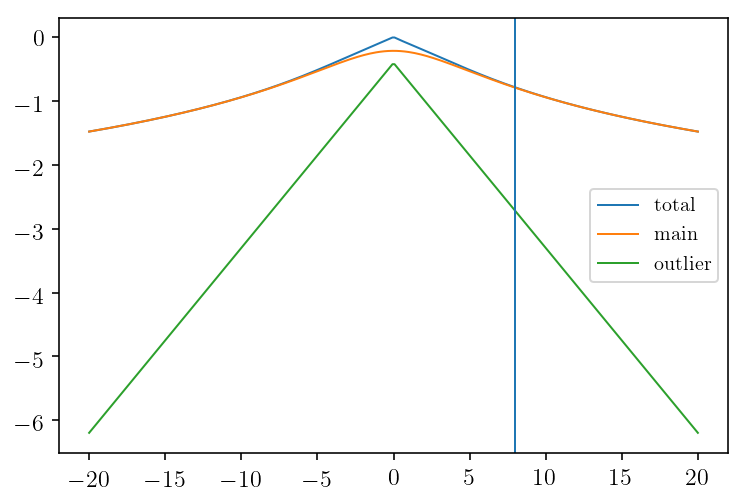

In [30]:
rs = np.ones(300)*8.
phis = np.zeros(300)
zs = np.linspace(-20.,20.,300)
tpar = [-1.,1.,0.6,0.01]
dens_sun = triaxial_with_expdisk_outlier(8.,0.,0.02, params=tpar)
plt.plot(zs,np.log10(triaxial_with_expdisk_outlier(rs,phis,zs, params=tpar)), label='total')
plt.plot(zs,np.log10(triaxial_with_expdisk_outlier(rs,phis,zs, params=tpar, just_main=True)), label='main')
plt.plot(zs,np.log10(triaxial_with_expdisk_outlier(rs,phis,zs, params=tpar, just_outlier=True)), label='outlier')


plt.axvline(8.)
plt.legend()

In [17]:
from scipy.optimize import newton

In [19]:
def q_re(re, q_0, q_inf, req):
    return q_inf - (q_inf-q_0)*np.exp(1-(np.sqrt(re**2+req**2)/req))

def r_e(re,x,y,z,p,q_0,q_inf,req):
    return re**2-x**2-y**2*p**-2-z**2*q_re(re,q_0,q_inf,req)**-2

In [45]:
xs = np.linspace(0.,3.,1000.)
sol = np.array([newton(r_e,np.sqrt(x**2),args=(0.,0.,x,0.3,0.1,0.5,2.)) for x in xs])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.



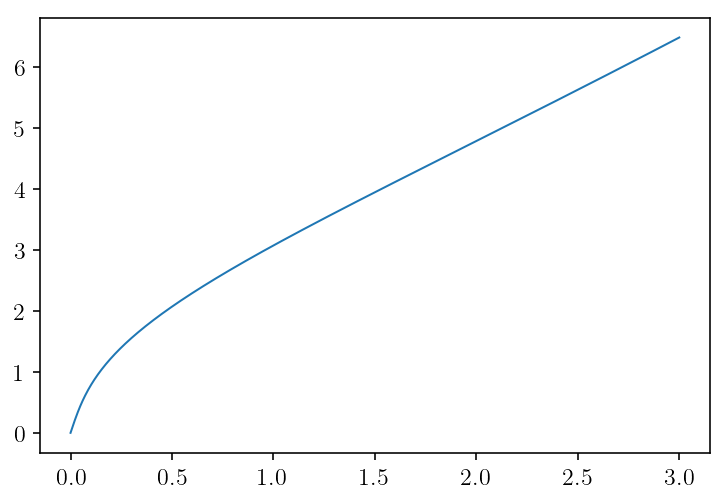

In [46]:
plt.plot(xs,sol)

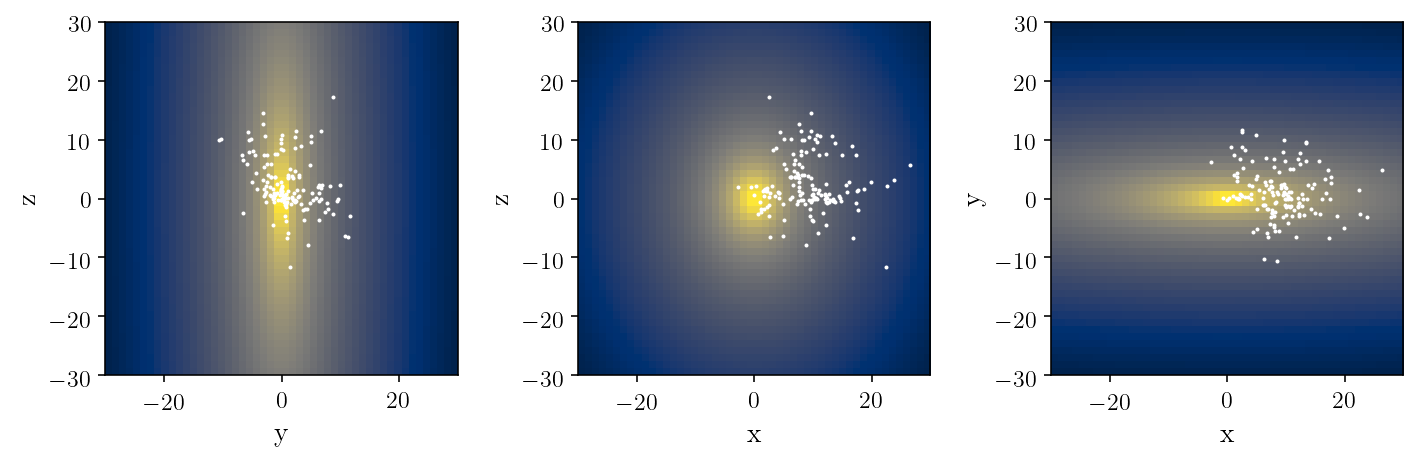

In [64]:
def transform_aby(xyz,alpha,beta,gamma):
    """
    Transform xyz coordinates by rotation around x-axis (alpha), transformed y-axis (beta) and twice transformed z-axis (gamma)
    """
    Rx = np.zeros([3,3])
    Ry = np.zeros([3,3])
    Rz = np.zeros([3,3])
    Rx[0,0] = 1
    Rx[1] = [0, np.cos(alpha), -np.sin(alpha)]
    Rx[2] = [0, np.sin(alpha), np.cos(alpha)]
    Ry[0] = [np.cos(beta), 0, np.sin(beta)]
    Ry[1,1] = 1
    Ry[2] = [-np.sin(beta), 0, np.cos(beta)]
    Rz[0] = [np.cos(gamma), -np.sin(gamma), 0]
    Rz[1] = [np.sin(gamma), np.cos(gamma), 0]
    Rz[2,2] = 1
    if np.ndim(xyz) == 1:
        tgalcenrect = np.dot(Rx, xyz)
        tgalcenrect = np.dot(Ry, tgalcenrect)
        tgalcenrect = np.dot(Rz, tgalcenrect)
        x, y, z = tgalcenrect[0], tgalcenrect[1], tgalcenrect[2]
    else:
        tgalcenrect = np.einsum('ij,aj->ai', Rz, xyz)
        tgalcenrect = np.einsum('ij,aj->ai', Ry, tgalcenrect)
        tgalcenrect = np.einsum('ij,aj->ai', Rx, tgalcenrect)
        x, y, z = tgalcenrect[:,0], tgalcenrect[:,1], tgalcenrect[:,2]
    return x, y, z

def q_re(re, q_0, q_inf, req):
    return q_inf - (q_inf-q_0)*np.exp(1-(np.sqrt(re**2+req**2)/req))

def r_e(re,x,y,z,p,q_0,q_inf,req):
    return re**2-x**2-y**2*p**-2-z**2*q_re(re,q_0,q_inf,req)**-2

def triaxialSP_iorio_qvar(R,phi,z,params=[2.,0.5,0.5,0.8,1/10.,0.,0.,0.]):
    grid = False
    alpha = (np.pi*params[5])-np.pi/2.
    beta = (np.pi*params[6])-np.pi/2.
    gamma = (np.pi*params[7])-np.pi/2.
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    x, y, z = transform_aby(np.dstack([x,y,z])[0], alpha,beta,gamma)
    xyz = np.dstack([x,y,z])[0]
    tr_e = np.array([newton(r_e,np.linalg.norm(txyz),args=(txyz[0],txyz[1],txyz[2],params[1],params[2],params[3],params[4])) for txyz in xyz])
    txsun, tysun, tzsun = transform_aby([8.,0.,0.02], alpha,beta,gamma)
    r_e_sun = newton(r_e,txsun,args=(txsun,tysun,tzsun,params[1],params[2],params[3],params[4]))
    dens = (tr_e)**(-params[0])
    sundens = (r_e_sun)**(-params[0])
    dens = dens/sundens
    if grid:
        dens = dens.reshape(dim)
    return dens

xyzgrid = np.mgrid[-30.:30.:50j,-30.:30.:50j,-30.:30.:50j]

shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
#rphizgrid = rphizgrid.reshape(100,100,100,3).T

denstxyz = triaxialSP_iorio_qvar(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=[2.,0.2,0.2,0.8,1/10.,0.5,0.5,0.5])

denstxyz = denstxyz.reshape(50,50,50)
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,10)
ax[0].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=0))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)
ax[1].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=1))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)
ax[2].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=2))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)

xdat, ydat, zdat = bovy_coords.cyl_to_rect(Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
ax[0].scatter(ydat, zdat, s=1., color='White')
ax[1].scatter(xdat, zdat, s=1., color='White')
ax[2].scatter(xdat, ydat, s=1., color='White')

ax[0].set_xlabel(r'y')
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'z')
ax[2].set_xlabel(r'x')
ax[2].set_ylabel(r'y')

for axis in ax:
    axis.set_ylim(-30,30)
    axis.set_xlim(-30,30)
fig.tight_layout()

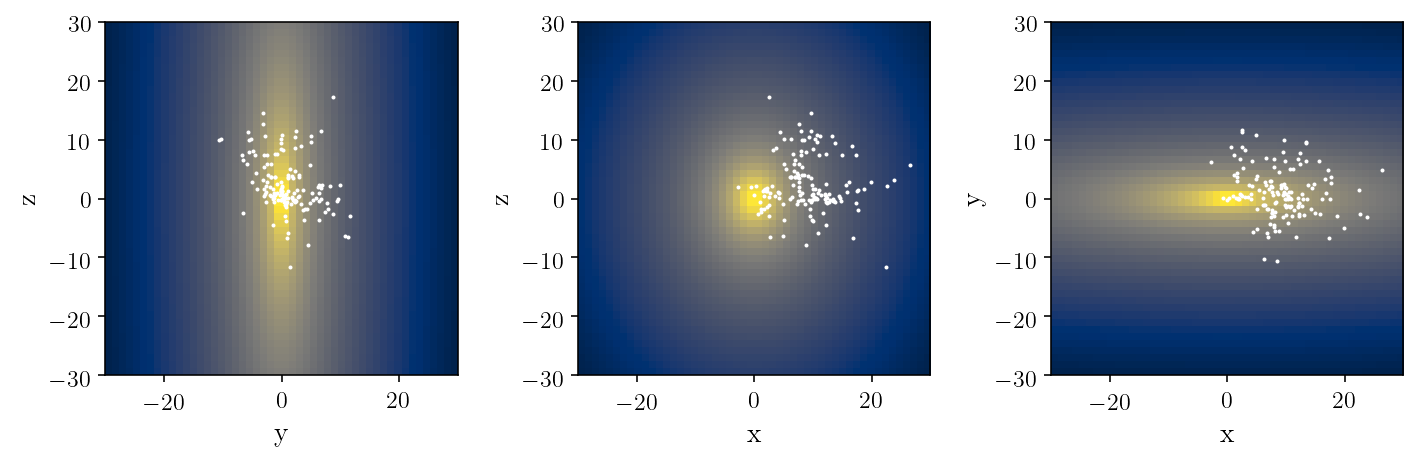

In [11]:
def transform_aby(xyz,alpha,beta,gamma):
    """
    Transform xyz coordinates by rotation around x-axis (alpha), transformed y-axis (beta) and twice transformed z-axis (gamma)
    """
    Rx = np.zeros([3,3])
    Ry = np.zeros([3,3])
    Rz = np.zeros([3,3])
    Rx[0,0] = 1
    Rx[1] = [0, np.cos(alpha), -np.sin(alpha)]
    Rx[2] = [0, np.sin(alpha), np.cos(alpha)]
    Ry[0] = [np.cos(beta), 0, np.sin(beta)]
    Ry[1,1] = 1
    Ry[2] = [-np.sin(beta), 0, np.cos(beta)]
    Rz[0] = [np.cos(gamma), -np.sin(gamma), 0]
    Rz[1] = [np.sin(gamma), np.cos(gamma), 0]
    Rz[2,2] = 1
    if np.ndim(xyz) == 1:
        tgalcenrect = np.dot(Rx, xyz)
        tgalcenrect = np.dot(Ry, tgalcenrect)
        tgalcenrect = np.dot(Rz, tgalcenrect)
        x, y, z = tgalcenrect[0], tgalcenrect[1], tgalcenrect[2]
    else:
        tgalcenrect = np.einsum('ij,aj->ai', Rz, xyz)
        tgalcenrect = np.einsum('ij,aj->ai', Ry, tgalcenrect)
        tgalcenrect = np.einsum('ij,aj->ai', Rx, tgalcenrect)
        x, y, z = tgalcenrect[:,0], tgalcenrect[:,1], tgalcenrect[:,2]
    return x, y, z



def q_re(re, q_0, q_inf, req):
    return q_inf - (q_inf-q_0)*np.exp(1-(np.sqrt(re**2+req**2)/req))

def r_e(re,x,y,z,p,q_0,q_inf,req):
    return re**2-x**2-y**2*p**-2-z**2*q_re(re,q_0,q_inf,req)**-2

def triaxialSP_iorio_qvar(R,phi,z,params=[2.,0.5,0.5,0.8,1/10.,0.,0.,0.]):
    grid = False
    alpha = (np.pi*params[5])-np.pi/2.
    beta = (np.pi*params[6])-np.pi/2.
    gamma = (np.pi*params[7])-np.pi/2.
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    x, y, z = transform_aby(np.dstack([x,y,z])[0], alpha,beta,gamma)
    xyz = np.dstack([x,y,z])[0]
    r = np.linalg.norm(xyz, axis=1)
    q_r = q_re(r,params[2],params[3],params[4])
    tr_e = np.sqrt(x**2+y**2/params[2]**2+z**2/q_r**2)
    txsun, tysun, tzsun = transform_aby([8.,0.,0.02], alpha,beta,gamma)
    r_e_sun = np.sqrt(txsun**2+tysun**2/params[2]**2+tzsun**2/q_r**2)
    dens = (tr_e)**(-params[0])
    sundens = (r_e_sun)**(-params[0])
    dens = dens/sundens
    if grid:
        dens = dens.reshape(dim)
    return dens

xyzgrid = np.mgrid[-30.:30.:50j,-30.:30.:50j,-30.:30.:50j]

shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
#rphizgrid = rphizgrid.reshape(100,100,100,3).T

denstxyz = triaxialSP_iorio_qvar(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=[2.,0.2,0.2,0.8,1/10.,0.5,0.5,0.5])

denstxyz = denstxyz.reshape(50,50,50)
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,10)
ax[0].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=0))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)
ax[1].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=1))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)
ax[2].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=2))), extent=[-30,30,-30,30], cmap=plt.cm.cividis)

xdat, ydat, zdat = bovy_coords.cyl_to_rect(Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
ax[0].scatter(ydat, zdat, s=1., color='White')
ax[1].scatter(xdat, zdat, s=1., color='White')
ax[2].scatter(xdat, ydat, s=1., color='White')

ax[0].set_xlabel(r'y')
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'z')
ax[2].set_xlabel(r'x')
ax[2].set_ylabel(r'y')

for axis in ax:
    axis.set_ylim(-30,30)
    axis.set_xlim(-30,30)
fig.tight_layout()

In [ ]:
allIndx = np.ones(len(glonglat), dtype=bool)
highbIndx = (np.fabs(glonglat[:,1]) > 10.)
base_mask = (allstar[statIndx]['LOGG'] < 3.) &\
       (allstar[statIndx]['LOGG'] > 1.) &\
       (allstar[statIndx]['FE_H'] > -1.3) &\
       (allstar[statIndx]['FE_H'] < -1.) &\
       (allstar[statIndx]['MG_FE'] < 0.2) &\
       (allstar[statIndx]['MG_FE'] > 0.)
control_mask = (allstar[statIndx]['LOGG'] < 3.) &\
       (allstar[statIndx]['LOGG'] > 1.) &\
       (allstar[statIndx]['FE_H'] > -1.3) &\
       (allstar[statIndx]['FE_H'] < -1.) &\
       (allstar[statIndx]['MG_FE'] < 0.5) &\
       (allstar[statIndx]['MG_FE'] > 0.25)

datahighb = base_mask & (np.fabs(allstar[statIndx]['GLAT']) > 10.)
cdatahighb = control_mask & (np.fabs(allstar[statIndx]['GLAT']) > 10.)
model = utils.triaxial_norot
init = [2.,0.2,0.2,0.8,1/10.,0.5,0.5,0.5]

locmasks = allIndx
datmasks = base_mask

datamask = datmasks[i]
tXYZ, tRphiz = allstar_to_coords(allstar[statIndx][datamask])
locmask = locmasks[i]
opt = mle_fit(tRphiz, model, init, locmask)
print(opt[0])
sampler = sample(tRphiz, model, opt[0], locmask)
ndim = len(opt[0])
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
masses = sample_mass(tRphiz, model, samples, avmass, massratio, datamask, locmask)
all_samples.append(samples)
all_masses.append(masses)

In [ ]:
flattened_model = """
functions {
    vector density(int ndata, vector R, vector phi, vector z, real alpha,real p,real b, real c) {
            vector[ndata] dens;
            real r0;
            real tr0;
            r0 = sqrt(8.^2+0.02^2);
            for (i in 1:ndata) {
                real r;
                real x;
                real y;
                x = R[i]*cos(phi[i]);
                y = R[i]*sin(phi[i]);
                r = x^2+y^2+z[i]^2/c^2;
                dens[i] = r0^alpha/r^alpha;
                }
            return dens;
            }
}
data {
    int<lower=0> ndistmods;
    int<lower=0> nfields;
    int<lower=0> ndata;
    vector[ndistmods] Rgrid[nfields];
    vector[ndistmods] phigrid[nfields];
    vector[ndistmods] zgrid[nfields];
    vector[ndistmods] effsel[nfields];
    vector[ndata] dataR;
    vector[ndata] dataphi;
    vector[ndata] dataz;
    
}
parameters {
    real<lower=0,upper=10.> alpha;
    real<lower=0.,upper=10.> a;
    real<lower=0.,upper=1.> c;
}
model {
    real datadens;
    vector[nfields] effvol_fields;
    c ~ normal(0.5,0.5);
    datadens = log(sum(density(ndata, dataR, dataphi, dataz, alpha,a,c)));
    for (i in 1:nfields) {
        effvol_fields[i] = sum(density(ndistmods, Rgrid[i], phigrid[i], zgrid[i], alpha, a,c).*effsel[i]);
    }
    target += datadens-ndata*log(sum(effvol_fields));
}
"""